In [ ]:
!pip install transformers torch pandas scikit-learn mlflow matplotlib seaborn wordcloud tensorflow tensorflow-data-validation zenml tweepy cassandra-driver


In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import numpy as np
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import numpy as np
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import BertTokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_data_validation as tfdv
import mlflow
import mlflow.tensorflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from zenml.steps import step
from zenml.pipelines import pipeline
import tweepy
import json
import requests
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import uuid
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import logging

In [2]:
# Importing necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import pandas as pd

# Constants and Hyperparameters
CSV_FILE_PATH = 'C:\\Users\\LENOVO\\Desktop\\CSC5382_SP24_FINALPROJECT\\scripts\\dataset_reduced.csv'  # Path to the dataset
PRETRAINED_LM_PATH = 'C:\\Users\\LENOVO\\CSC5382_SP24_FINALPROJECT\\scripts\\bert-election2024-twitter-stance-biden'  # Path to the pre-trained language model
HYPERPARAMS = {
    "batch_size": 16,          # Batch size for training
    "learning_rate": 2e-5,     # Learning rate for the optimizer
    "epochs": 2,               # Number of training epochs
    "weight_decay": 0.01,      # Weight decay for regularization
    'max_grad_norm': 1.0,      # Maximum gradient norm for gradient clipping
    'lr_step_size': 1,         # Step size for learning rate scheduler
    'lr_gamma': 0.1,           # Gamma factor for learning rate scheduler
}

# Print hyperparameters
print("Hyperparameters:", HYPERPARAMS)


Hyperparameters: {'batch_size': 16, 'learning_rate': 2e-05, 'epochs': 2, 'weight_decay': 0.01, 'max_grad_norm': 1.0, 'lr_step_size': 1, 'lr_gamma': 0.1}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


   model_id score_threshold    k attribute_name attribute_value  accuracy  \
0         0      binary 0/1  338      attribute          group1       1.0   
1         0      binary 0/1  338      attribute          group2       1.0   

   tpr  tnr  for  fdr  ...  FNR Parity  TPR Parity  TNR Parity  NPV Parity  \
0  1.0  1.0  0.0  0.0  ...         NaN        True        True        True   
1  1.0  1.0  0.0  0.0  ...         NaN        True        True        True   

   Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0              True           NaN            NaN           False   
1              True           NaN            NaN           False   

   Unsupervised Fairness  Supervised Fairness  
0                   True                  NaN  
1                   True                  NaN  

[2 rows x 62 columns]
Index(['model_id', 'score_threshold', 'k', 'attribute_name', 'attribute_value',
       'accuracy', 'tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 'npv',
       'preci

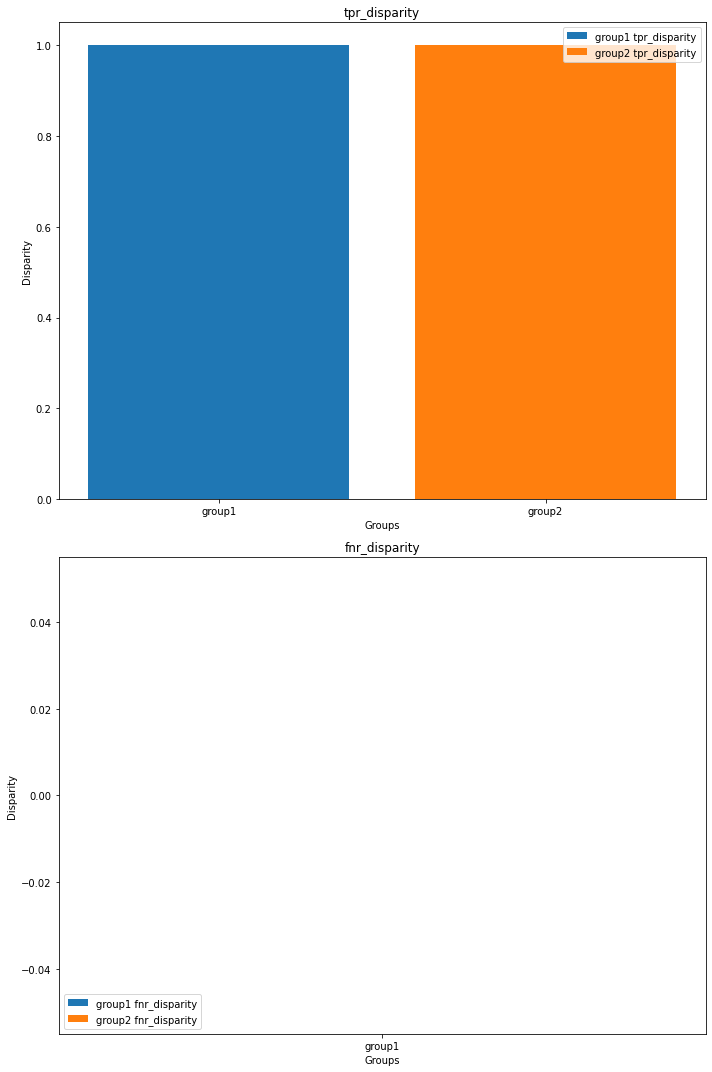

In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import numpy as np
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import re
import matplotlib.pyplot as plt

# Load the model and tokenizer
MODEL_PATH = 'C:\\Users\\LENOVO\\Desktop\\CSC5382_SP24_FINALPROJECT\\scripts\\bert-election2024-twitter-stance-biden'
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
model = BertForSequenceClassification.from_pretrained(MODEL_PATH)

# Load your dataset
CSV_FILE_PATH = 'C:\\Users\\LENOVO\\Desktop\\CSC5382_SP24_FINALPROJECT\\scripts\\dataset_reduced.csv'
data = pd.read_csv(CSV_FILE_PATH) 

# Map labels to numerical values
label_mapping = {'NONE': 0, 'FAVOR': 1, 'AGAINST': 2}
data['label'] = data['label'].map(label_mapping)

# Binarize the scores: Consider 'FAVOR' (1) as positive, 'NONE' (0) and 'AGAINST' (2) as negative
data['score'] = data['label'].apply(lambda x: 1 if x == 1 else 0)

# Prepare data for Aequitas
aequitas_data = pd.DataFrame()
aequitas_data['score'] = data['score']
aequitas_data['label_value'] = data['score'] # Same as score because we already binarized it

# Add demographic data (for example purposes, let's assume we have 'demographic' column in your dataset)
# In a real-world scenario, you should replace this with actual demographic data
aequitas_data['attribute'] = data['demographic'] if 'demographic' in data.columns else np.random.choice(['group1', 'group2'], len(data))

# Group metric calculation
group = Group()
xtab, _ = group.get_crosstabs(aequitas_data)

# Bias calculation
bias = Bias()
bdf = bias.get_disparity_predefined_groups(xtab, original_df=aequitas_data, ref_groups_dict={'attribute': 'group1'}, alpha=0.05, mask_significance=True)

# Fairness calculation
fairness = Fairness()
fdf = fairness.get_group_value_fairness(bdf)

# Display results
print(fdf)

# Check available metrics in fdf
print(fdf.columns)

# Define the metrics to plot based on the available columns
available_metrics = ['tpr_disparity', 'fnr_disparity']  # Update this list based on the printed columns
groups = fdf['attribute_value'].unique()

# Plot results
fig, ax = plt.subplots(len(available_metrics), 1, figsize=(10, 15))

for i, metric in enumerate(available_metrics):
    for group in groups:
        group_data = fdf[fdf['attribute_value'] == group]
        ax[i].bar(group, group_data[metric].values[0], label=f'{group} {metric}')
    ax[i].set_title(f'{metric}')
    ax[i].set_xlabel('Groups')
    ax[i].set_ylabel('Disparity')
    ax[i].legend()

plt.tight_layout()
plt.show()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


   model_id score_threshold    k attribute_name attribute_value  accuracy  \
0         0      binary 0/1  338      attribute          group1       1.0   
1         0      binary 0/1  338      attribute          group2       1.0   

   tpr  tnr  for  fdr  ...  FNR Parity  TPR Parity  TNR Parity  NPV Parity  \
0  1.0  1.0  0.0  0.0  ...         NaN        True        True        True   
1  1.0  1.0  0.0  0.0  ...         NaN        True        True        True   

   Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0              True           NaN            NaN           False   
1              True           NaN            NaN           False   

   Unsupervised Fairness  Supervised Fairness  
0                   True                  NaN  
1                   True                  NaN  

[2 rows x 62 columns]
Index(['model_id', 'score_threshold', 'k', 'attribute_name', 'attribute_value',
       'accuracy', 'tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 'npv',
       'preci

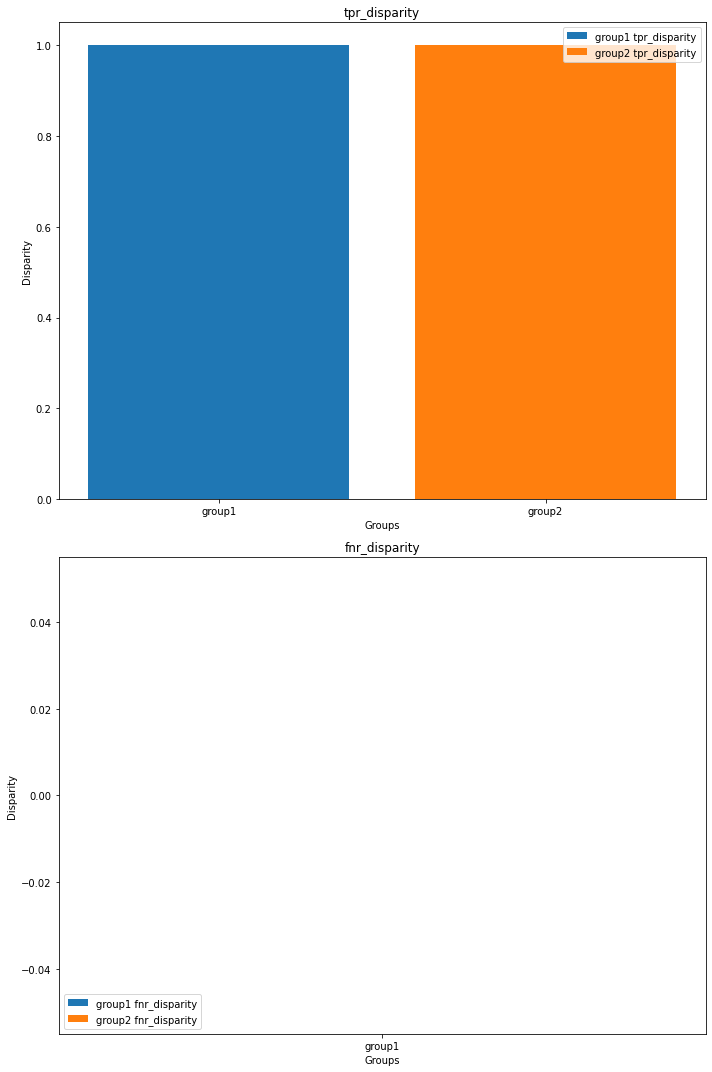

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import numpy as np
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import re
import shap
import matplotlib.pyplot as plt

# Load the model and tokenizer
MODEL_PATH = 'C:\\Users\\LENOVO\\Desktop\\CSC5382_SP24_FINALPROJECT\\scripts\\bert-election2024-twitter-stance-biden'
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
model = BertForSequenceClassification.from_pretrained(MODEL_PATH)

# Load your dataset
CSV_FILE_PATH = 'C:\\Users\\LENOVO\\Desktop\\CSC5382_SP24_FINALPROJECT\\scripts\\dataset_reduced.csv'
data = pd.read_csv(CSV_FILE_PATH)

# Map labels to numerical values
label_mapping = {'NONE': 0, 'FAVOR': 1, 'AGAINST': 2}
data['label'] = data['label'].map(label_mapping)

# Binarize the scores: Consider 'FAVOR' (1) as positive, 'NONE' (0) and 'AGAINST' (2) as negative
data['score'] = data['label'].apply(lambda x: 1 if x == 1 else 0)

# Prepare data for Aequitas
aequitas_data = pd.DataFrame()
aequitas_data['score'] = data['score']
aequitas_data['label_value'] = data['score'] # Same as score because we already binarized it

# Add demographic data (for example purposes, let's assume we have 'demographic' column in your dataset)
# In a real-world scenario, you should replace this with actual demographic data
aequitas_data['attribute'] = data['demographic'] if 'demographic' in data.columns else np.random.choice(['group1', 'group2'], len(data))

# Group metric calculation
group = Group()
xtab, _ = group.get_crosstabs(aequitas_data)

# Bias calculation
bias = Bias()
bdf = bias.get_disparity_predefined_groups(xtab, original_df=aequitas_data, ref_groups_dict={'attribute': 'group1'}, alpha=0.05, mask_significance=True)

# Fairness calculation
fairness = Fairness()
fdf = fairness.get_group_value_fairness(bdf)

# Display results
print(fdf)

# Check available metrics in fdf
print(fdf.columns)

# Define the metrics to plot based on the available columns
available_metrics = ['tpr_disparity', 'fnr_disparity']  # Update this list based on the printed columns
groups = fdf['attribute_value'].unique()

# Plot results
fig, ax = plt.subplots(len(available_metrics), 1, figsize=(10, 15))

for i, metric in enumerate(available_metrics):
    for group in groups:
        group_data = fdf[fdf['attribute_value'] == group]
        ax[i].bar(group, group_data[metric].values[0], label=f'{group} {metric}')
    ax[i].set_title(f'{metric}')
    ax[i].set_xlabel('Groups')
    ax[i].set_ylabel('Disparity')
    ax[i].legend()

plt.tight_layout()
plt.show()

# SHAP analysis for model explainability
# Tokenize the data
tokenized_data = data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# Pad sequences to the same length
max_len = max([len(i) for i in tokenized_data])
padded_data = np.array([i + [0]*(max_len-len(i)) for i in tokenized_data])

# Define a prediction function
def predict(inputs):
    inputs = torch.tensor(inputs).to(torch.int64)  # Ensure inputs are in the correct format
    with torch.no_grad():
        outputs = model(inputs)[0]
    return outputs.cpu().numpy()

# Create SHAP explainer using KernelExplainer
background = padded_data[:100]  # Use a subset as the background for the explainer
explainer = shap.KernelExplainer(predict, background)

# Select a subset of data to explain
sample_data = padded_data[:10]

# Get SHAP values
shap_values = explainer.shap_values(sample_data)

# Plot SHAP values for the first prediction
shap.summary_plot(shap_values, features=sample_data, feature_names=tokenizer.convert_ids_to_tokens(range(max_len)))


In [3]:
# Check if the CSV file path is correct and accessible
if not os.path.exists(CSV_FILE_PATH):
    raise FileNotFoundError(f"CSV file not found at: {CSV_FILE_PATH}")

# Load data from CSV file into a DataFrame
data = pd.read_csv(CSV_FILE_PATH)  # Reading the dataset from CSV file

# Additional Features and Comments:
# - This step loads the dataset from a CSV file into a pandas DataFrame for further processing.
# - It assumes that the CSV file is structured with rows representing data instances and columns representing features.
# - Ensure that the CSV file path is correct and accessible.
# - It's advisable to check the structure of the loaded data (e.g., using data.head()) to ensure it's loaded correctly.
# - Further data preprocessing steps such as handling missing values, encoding categorical variables, or feature scaling
#   can be applied depending on the specific requirements of the machine learning task.

In [4]:
# Set tweet_id as the index of the DataFrame
data.set_index('tweet_id', inplace=True)  # Setting 'tweet_id' as the index inplace


In [5]:
# Display the first 5 rows of the DataFrame 'data' to quickly inspect the initial entries
# and check for the presence and format of data in the columns.
data.head()


,text,label
tweet_id,,
1,Biden is the best candidate for the job. #Bide...,FAVOR
2,@USER I can't trust Biden's policies. He's not...,AGAINST
3,Let's support Biden in his efforts to improve ...,FAVOR
4,I don't understand why anyone would vote for B...,AGAINST
5,@USER Biden's environmental policies are exact...,FAVOR


In [6]:
# Check if there are any null values in the entire DataFrame 'data'.
if data.isnull().values.any():
    # Calculate the sum of null values for each column and store it in 'null_counts'.
    null_counts = data.isnull().sum()
    
    # Print a warning message to indicate the presence of null values in the dataset.
    print("Warning: Null values found in the dataset.")
    
    # Print the count of null values for each column where the count is greater than zero.
    print(f"Null value counts by column:\n{null_counts[null_counts > 0]}")


In [ ]:
# Define a set of expected column names for the dataset, specifically 'text' and 'label'.
# This set will be used to verify that the dataset contains these essential columns.
expected_columns = {'text', 'label'}


In [ ]:
# Display a concise summary of the DataFrame 'data', including the number of entries,
# the name and type of each column, the number of non-null values in each column,
# and the memory usage. This helps in getting an overview of the dataset's structure
# and any potential issues with data types or missing values.
data.info()


    <class 'pandas.core.frame.DataFrame'> 
    # This indicates that 'data' is a pandas DataFrame, a 2D size-mutable, potentially heterogeneous tabular data structure with labeled axes.

    Int64Index: 11 entries, 1298098337946783745 to 1239394168939503617 
    # The DataFrame 'data' uses an Integer index (Int64Index) and contains 11 entries.
    # These entries are indexed from 1298098337946783745 to 1239394168939503617.

    Data columns (total 2 columns): 
    # The DataFrame consists of two columns.

    #   Column  Non-Null Count  Dtype 
    ---  ------  --------------  ----- 
    0   text    11 non-null     object 
    # Column 'text' has 11 entries, all of which are non-null (i.e., no missing values).
    # The datatype (Dtype) of this column is 'object', typically used in pandas to denote string data.

    1   label   11 non-null     object
    # Column 'label' also has 11 non-null entries, indicating no missing values in this column either.
    # This column's datatype is also 'object', suggesting that it may contain string data.

    dtypes: object(2)
    # This confirms that both columns in the DataFrame are of type 'object'.

    memory usage: 264.0 bytes
    # The entire DataFrame consumes 264 bytes of memory.


In [ ]:
# Calculate and return a Series containing the count of missing values in each column of the DataFrame 'data'.
# This function checks for null values across each column and sums them up, providing a quick overview
# of the data cleanliness and where missing values are concentrated.
data.isnull().sum()


In [ ]:
# Access and return the 11th entry (index 10) from the 'text' column of the DataFrame 'data'.
# This is done using the 'iloc' indexer, which works on the basis of integer index positions.
# This specific call retrieves the data from the 11th position in the 'text' column, useful for inspecting or processing a specific item.
data.text.iloc[10]


In [ ]:
# Compute and return the counts of unique values in the 'label' column of the DataFrame 'data'.
# This method tallies how many times each unique value appears in the 'label' column,
# providing a quick summary of the distribution of categories within the data.
# It is useful for understanding the balance or imbalance among different classes in a dataset.
data.label.value_counts()


In [ ]:
# Import visualization libraries
import matplotlib.pyplot as plt  # Import matplotlib's pyplot module for creating static, interactive, and animated visualizations in Python.
import seaborn as sns           # Import seaborn, a Python data visualization library based on matplotlib, providing a high-level interface for drawing attractive statistical graphics.

# Set up the plot dimensions
plt.figure(figsize=(40, 5))  # Create a new figure with a specified figure size of 40 inches in width and 5 inches in height.

# Create a count plot
sns.countplot(data.label, palette='Spectral')  # Use seaborn's countplot to show the counts of observations in each categorical bin using bars.
                                               # 'data.label' specifies the column in DataFrame from which to draw the categories.
                                               # 'palette' is set to 'Spectral' to define the color palette of the plot.

# Set plot labels and title
plt.xlabel('Classes')  # Set the x-axis label of the plot to 'Classes'.
plt.title('Class Distribution')  # Set the title of the plot to 'Class Distribution'.


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Generate a pie chart
plt.figure(figsize=(8, 8))  # Set up the figure size for the pie chart
class_counts = data.label.value_counts()  # Count occurrences of each class in the 'label' column
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Spectral(np.linspace(0, 1, len(class_counts))))  # Create a pie chart
plt.title('Proportion of Each Class')  # Add a title to the pie chart

# Display the plot
plt.show()  # Show the pie chart in the output cell of the notebook


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zenml.steps import step, Output

@step
def data_analysis_step(CSV_FILE_PATH: str) -> Output(null_counts=pd.Series, class_distribution_fig=object):
    # Load the data
    data = pd.read_csv(CSV_FILE_PATH)
    data.set_index('tweet_id', inplace=True)

    # Display head of the dataframe
    print(data.head())

    # Check for null values
    if data.isnull().values.any():
        null_counts = data.isnull().sum()
        print("Warning: Null values found in the dataset.")
        print(f"Null value counts by column:\n{null_counts[null_counts > 0]}")

    # Display dataset info
    data.info()

    # Count nulls
    print(data.isnull().sum())

    # Access a specific element
    print(data.text.iloc[10])

    # Value counts for 'label'
    print(data.label.value_counts())

    # Plotting the class distribution
    plt.figure(figsize=(10, 5))
    sns.countplot(x=data.label, palette='Spectral')
    plt.xlabel('Classes')
    plt.title('Class Distribution')
    plt.show()

    # Return the null_counts and the figure (the figure as an example, handling of plt.figure in real applications may vary)
    return null_counts, plt.gcf()

# Note: In real deployment, you might want to handle outputs differently, such as saving them to files or databases.


In [ ]:
def clean_text(text):
        """
        Function to clean text data.

        Args:
            text (str): Text to be cleaned.

        Returns:
            str: Cleaned text.
        """
        # Removing URLs
        text = re.sub(r'http\S+', '', text)
        # Removing usernames and hashtags
        text = re.sub(r'@\S+|#\S+', '', text)
        # Removing special characters and numbers
        text = re.sub(r'[^A-Za-z\s]', '', text)
        # Converting to lowercase
        text = text.lower().strip()
        # Tokenize and rejoin the text to ensure clean tokenization
        tokens = text.split()
        return ' '.join(tokens)

In [ ]:
# Define a set of expected column names for the dataset: 'text' and 'label'.
expected_columns = {'text', 'label'}

# Check if the expected columns are present in the DataFrame 'data'.
if not expected_columns.issubset(data.columns):
    # Calculate the set difference to identify which expected columns are missing from the DataFrame.
    missing_cols = expected_columns - set(data.columns)
    
    # Construct an error message stating which columns are missing.
    error_msg = f"The dataframe is missing the following required columns: {', '.join(missing_cols)}"
    
    # Log the error message using the logging library.
    logging.error(error_msg)
    
    # Raise a ValueError to stop execution and alert the user to the missing necessary columns.
    raise ValueError(error_msg)


In [ ]:
# Define a set of expected column names and their expected data types for the dataset: 'text' as string and 'label' as string.
expected_columns_and_types = {'text': 'object', 'label': 'object'}

# Check if the expected columns are present in the DataFrame 'data'.
if not set(expected_columns_and_types.keys()).issubset(data.columns):
    missing_cols = set(expected_columns_and_types.keys()) - set(data.columns)
    error_msg = f"The dataframe is missing the following required columns: {', '.join(missing_cols)}"
    logging.error(error_msg)
    raise ValueError(error_msg)

# Verify that each column has the correct data type.
incorrect_type_cols = {col: expected_type for col, expected_type in expected_columns_and_types.items()
                       if data[col].dtype != expected_type}
if incorrect_type_cols:
    error_msg_type = f"The dataframe has incorrect data types for the columns: {', '.join(f'{col}: expected {etype}, found {data[col].dtype}' for col, etype in incorrect_type_cols.items())}"
    logging.error(error_msg_type)
    raise ValueError(error_msg_type)


In [ ]:
# Output a message to indicate that data preprocessing is beginning.
print("Preprocessing the data...")

# Identify and store rows where the 'label' column is missing data.
missing_label_rows = data[data['label'].isna()]

# Check if there are any rows with missing labels and handle them accordingly.
if not missing_label_rows.empty:
    print(f"Found {len(missing_label_rows)} rows with missing labels.")
    # Option to handle missing data: Remove, Impute, or other logic.
    # For example, removing rows with missing labels:
    data = data.dropna(subset=['label'])
    print("Missing label rows have been removed.")
else:
    print("No missing labels found.")


In [ ]:
# Print the number of rows before removal for debugging and verification purposes.
print(f"Number of rows before removal of missing labels: {len(data)}")

# Remove rows from the DataFrame 'data' where the 'label' column contains missing values.
data.dropna(subset=['label'], inplace=True)

# Verify and output the number of rows after removal to ensure that the operation was successful.
print(f"Number of rows after removal of missing labels: {len(data)}")


In [ ]:
# Check for the presence of rows with missing labels and log them if any.
if not missing_label_rows.empty:
    print(f"Rows with missing labels:\n{missing_label_rows}")
else:
    # Log when no missing label rows are found, which is good for confirming data quality.
    print("No missing label rows found.")

# After removing rows with missing labels, check if the DataFrame 'data' has become empty.
if data.empty:
    print("The DataFrame is empty after preprocessing.")
    # Depending on the application, you might want to handle an empty DataFrame specifically.
    # For example, you might raise an exception or trigger an alert in a production environment.
    raise ValueError("Critical error: Data processing resulted in an empty dataset.")

In [ ]:
# Encode labels: Convert categorical labels from strings to integers for further analysis or modeling.
# This mapping is crucial for many machine learning algorithms that require numerical input.
label_mapping = {'NONE': 0, 'FAVOR': 1, 'AGAINST': 2}  # Define a dictionary to map string labels to integers.

# Apply the mapping to the 'label' column in the DataFrame 'data'.
# This replaces the string labels in the 'label' column with their corresponding integer codes.
data['label'] = data['label'].map(label_mapping)


In [ ]:
data.head(15)

In [ ]:
# Validate the encoding: Ensure that all categorical labels have been converted to the predefined numerical codes.
unique_labels = data['label'].unique()  # Extract unique values from the 'label' column to check the encoding results.

# Check if the unique labels in the dataset match the expected set of numerical codes {0, 1, 2}.
if set(unique_labels) != {0, 1, 2}:
    # Prepare an error message detailing the mismatch in expected and actual unique labels.
    error_msg = f"Labels are not correctly mapped. Found unique labels: {unique_labels}"
    
    # Log the error message to help with debugging and ensuring the issue is recorded.
    logging.error(error_msg)
    
    # Raise a ValueError to stop the execution and signal that the label encoding has issues.
    raise ValueError(error_msg)


In [ ]:
# Validate the encoding and suggest corrections if mismatches are found.
unique_labels = data['label'].unique()
expected_labels = {0, 1, 2}

if set(unique_labels) != expected_labels:
    error_msg = f"Labels are not correctly mapped. Found unique labels: {unique_labels}, expected labels were {expected_labels}."
    logging.error(error_msg)
    
    # Suggest checking the label_mapping dictionary or reviewing the source data for inconsistencies.
    corrective_action = "Please review the label_mapping dictionary and the source data for any inconsistencies."
    logging.info(corrective_action)
    
    # Raise an error with both the problem and suggested corrective actions.
    raise ValueError(f"{error_msg} {corrective_action}")


In [ ]:
import mlflow
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def load_data(file_path):
    df = pd.read_csv(file_path, usecols=['text', 'label'])
    return df

def train_model(model, tokenizer, data, label_to_index):
    train_encodings = tokenizer(data['text'].tolist(), truncation=True, padding=True, max_length=512)
    train_labels = [label_to_index[label] for label in data['label']]
    train_dataset = TextDataset(train_encodings, train_labels)

    training_args = TrainingArguments(
        output_dir='./results',          # output directory
        num_train_epochs=3,              # number of training epochs
        per_device_train_batch_size=8,   # batch size for training
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        compute_metrics=None
    )

    trainer.train()

file_path = "C:\\Users\\LENOVO\\Desktop\\CSC5382_SP24_FINALPROJECT\\scripts\\dataset_reduced.csv"
data = load_data(file_path)

mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("experiment_bert-base-uncased")

with mlflow.start_run(run_name="bert-base-uncased-finetuned"):
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(data['label'].unique()))

    # Mapping labels to numeric indices for processing
    label_to_index = {label: idx for idx, label in enumerate(data['label'].unique())}

    # Log the model parameters
    mlflow.log_param("model_name", model_name)

    # Train the model
    train_model(model, tokenizer, data, label_to_index)
    
    # Assuming you have a validation or test set, you would evaluate it here
    # For demonstration, we assume 'data' contains some training data.
    # evaluation results would typically go here

    # Log metrics to MLflow
    mlflow.log_metrics({"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1})


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import pandas as pd
from torch.utils.data import Dataset

# Assuming you've defined TextDataset and load_data as before
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df['text'], df['label'].astype(int)  # Ensure labels are integer

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # Set num_labels appropriately

# Prepare data
texts, labels = load_data("C:\\Users\\LENOVO\\Desktop\\CSC5382_SP24_FINALPROJECT\\scripts\\dataset_reduced.csv")
encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=512)
dataset = TextDataset(encodings, labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory for model and logs
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    compute_metrics=None  # Define compute_metrics function if needed
)

# Start training
trainer.train()


In [ ]:
import mlflow
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def load_data(file_path):
    df = pd.read_csv(file_path, usecols=['text', 'label'])
    return df

def train_model(model, tokenizer, data, label_to_index):
    train_encodings = tokenizer(data['text'].tolist(), truncation=True, padding=True, max_length=512)
    train_labels = [label_to_index[label] for label in data['label']]
    train_dataset = TextDataset(train_encodings, train_labels)

    training_args = TrainingArguments(
        output_dir='./results',          # output directory
        num_train_epochs=3,              # number of training epochs
        per_device_train_batch_size=8,   # batch size for training
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        compute_metrics=None
    )

    trainer.train()

file_path = "C:\\Users\\LENOVO\\Desktop\\CSC5382_SP24_FINALPROJECT\\scripts\\dataset_reduced.csv"
data = load_data(file_path)

# Set a new experiment name
mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("experiment_distilbert-base-uncased")

with mlflow.start_run(run_name="distilbert-base-uncased-finetuned"):
    model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(data['label'].unique()))

    # Mapping labels to numeric indices for processing
    label_to_index = {label: idx for idx, label in enumerate(data['label'].unique())}

    # Log the model parameters
    mlflow.log_param("model_name", model_name)

    # Train the model
    train_model(model, tokenizer, data, label_to_index)
    
    # Here you would ideally have a separate evaluation phase with your validation/test set
    # For now, this example assumes that the training function encompasses all necessary processes
    # Log metrics to MLflow
    mlflow.log_metrics({"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1})



In [ ]:
import mlflow
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

def load_data(file_path):
    df = pd.read_csv(file_path, usecols=['text', 'label'])
    # Assuming label mapping needs to be consistent with model's output
    unique_labels = sorted(df['label'].unique())
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    df['label'] = df['label'].map(label_to_index)  # Map textual labels to indices
    return df, label_to_index

def evaluate_model(model, tokenizer, dataset):
    model.eval()
    predictions, true_labels = [], []

    loader = DataLoader(dataset, batch_size=16, shuffle=False)
    for batch in loader:
        inputs = {key: val.to(model.device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

file_path = "C:\\Users\\LENOVO\\Desktop\\CSC5382_SP24_FINALPROJECT\\scripts\\dataset_reduced.csv"
data, label_to_index = load_data(file_path)

mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("experiment_bert-election2020-twitter-stance-biden")


with mlflow.start_run(run_name="bert-election2020-twitter-stance-biden-evaluation"):
    model_name = "kornosk/bert-election2020-twitter-stance-biden"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    encodings = tokenizer(data['text'].tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")
    dataset = TextDataset(encodings, data['label'].tolist())

    accuracy, precision, recall, f1 = evaluate_model(model, tokenizer, dataset)

    mlflow.log_param("model_name", model_name)
    mlflow.log_metrics({"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1})


In [ ]:
import gradio as gr

gr.load("models/kornosk/bert-election2020-twitter-stance-biden").launch()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the length of each sentence in the 'text' column to prepare data for histogram
sentence_lengths = [len(s) for s in data.text]

# Create a histogram plot to visualize the distribution of sentence lengths
plt.figure(figsize=(10, 5))  # Set the size of the plot
sns.histplot(sentence_lengths, bins=100, color='skyblue', edgecolor='black')  # Create a histogram with 100 bins
plt.title('Sentence Length Distribution')  # Set the title of the histogram
plt.xlabel('Sentence Length')  # Label the x-axis as 'Sentence Length'
plt.ylabel('Frequency')  # Label the y-axis as 'Frequency'
plt.grid(True)  # Enable grid to improve readability
plt.show()  # Display the plot


In [ ]:
import numpy as np

# Compute mean and median sentence length
mean_len = np.mean(sentence_lengths)
median_len = np.median(sentence_lengths)

# Add vertical lines for mean and median to the plot
plt.axvline(mean_len, color='r', linestyle='--', linewidth=1, label=f'Mean: {mean_len:.2f}')
plt.axvline(median_len, color='g', linestyle='-', linewidth=1, label=f'Median: {median_len:.2f}')

# Add a legend to the plot to explain the additional lines
plt.legend()


In [ ]:
# Visualize Missing Values
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
missing_df = pd.DataFrame({'Feature': missing_values.index, 'MissingValues': missing_values, 'Percentage': missing_percentage})
# Filter out features with no missing values
missing_df = missing_df[missing_df['MissingValues'] > 0].sort_values('Percentage', ascending=False)
# Plotting missing values (if there are any)
if not missing_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Percentage', y='Feature', data=missing_df)
    plt.title('Percentage of Missing Values per Feature')
    plt.xlabel('Percentage')
    plt.ylabel('Feature')
    plt.show()
else:
    print("No missing values found in the dataset.")


In [ ]:
# Import necessary libraries
import re
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zenml.steps import step, Output

@step
def preprocess_and_visualize_step(data: pd.DataFrame) -> Output(processed_data=pd.DataFrame, figures=list):
    """
    Step to preprocess and visualize data.

    Args:
        data (pd.DataFrame): Dataframe to be processed.

    Returns:
        pd.DataFrame: Processed data.
        list: List of matplotlib figure objects.
    """
    def clean_text(text):
        """
        Function to clean text data.
        """
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'@\S+|#\S+', '', text)
        text = re.sub(r'[^A-Za-z\s]', '', text)
        text = text.lower().strip()
        tokens = text.split()
        return ' '.join(tokens)

    expected_columns = {'text', 'label'}
    if not expected_columns.issubset(data.columns):
        missing_cols = expected_columns - set(data.columns)
        error_msg = f"The dataframe is missing the following required columns: {', '.join(missing_cols)}"
        logging.error(error_msg)
        raise ValueError(error_msg)

    print("Preprocessing the data...")
    # Apply the cleaning function to the text column
    data['text'] = data['text'].apply(clean_text)

    # Drop rows where 'label' is NaN
    data.dropna(subset=['label'], inplace=True)

    # Encode labels
    label_mapping = {'NONE': 0, 'FAVOR': 1, 'AGAINST': 2}
    data['label'] = data['label'].map(label_mapping)

    # Validate the encoding
    unique_labels = data['label'].unique()
    if set(unique_labels) != {0, 1, 2}:
        error_msg = f"Labels are not correctly mapped. Found unique labels: {unique_labels}"
        logging.error(error_msg)
        raise ValueError(error_msg)

    # Visualization of sentence length
    fig1 = plt.figure(figsize=(10, 5))
    sns.histplot([len(s) for s in data['text']], bins=100)
    plt.title('Sentence Length')
    plt.show()

    # Visualization of Missing Values
    missing_values = data.isnull().sum()
    missing_percentage = (missing_values / len(data)) * 100
    missing_df = pd.DataFrame({'Feature': missing_values.index, 'MissingValues': missing_values, 'Percentage': missing_percentage})
    missing_df = missing_df[missing_df['MissingValues'] > 0].sort_values('Percentage', ascending=False)

    if not missing_df.empty:
        fig2 = plt.figure(figsize=(10, 6))
        sns.barplot(x='Percentage', y='Feature', data=missing_df)
        plt.title('Percentage of Missing Values per Feature')
        plt.xlabel('Percentage')
        plt.ylabel('Feature')
        plt.show()
    else:
        print("No missing values found in the dataset.")
    
    return data, [fig1, fig2] if not missing_df.empty else [fig1]

# This setup assumes logging is configured elsewhere in your application.


In [ ]:
# Data Distribution Visualization
# Check if the 'label' column exists in the DataFrame to ensure the relevant data is available for visualization.
if 'label' in data.columns:
    plt.figure(figsize=(8, 4))  # Set the size of the plot for clear visibility
    sns.countplot(x='label', data=data, palette='viridis')  # Create a count plot for the 'label' column with a visually appealing color palette
    plt.title('Distribution of Labels')  # Title of the plot, describing what is being visualized
    plt.xlabel('Label')  # Label for the x-axis, indicating what the values represent
    plt.ylabel('Count')  # Label for the y-axis, indicating the quantity being measured
    plt.xticks(rotation=45)  # Rotate the labels on the x-axis for better readability if they are long or numerous
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add a grid to the y-axis to enhance readability of the count values
    plt.show()  # Display the plot
else:
    # If the 'label' column is not found, output a message and skip the visualization step.
    print("Label column not found, skipping label distribution visualization.")


In [ ]:
# Dynamically adjust the rotation of x-axis labels based on the number of unique labels
label_count = data['label'].nunique()
rotation_angle = 45 if label_count > 5 else 0  # Rotate only if there are more than 5 labels to avoid clutter

# Apply the rotation
plt.xticks(rotation=rotation_angle)

# Dynamically adjust plot size based on label count
fig_width = max(8, label_count)  # Ensure the plot width is adequate to display all labels without overlapping
plt.figure(figsize=(fig_width, 4))


In [ ]:
# Define the size for your test and validation sets
test_size = 0.2
validation_size = 0.1

# Initial split to separate out the test set
train_val_data, test_data = train_test_split(data, test_size=test_size, random_state=42)

# Calculate the adjusted validation size based on the remaining data after test split
adjusted_validation_size = validation_size / (1 - test_size)

# Split the remaining data into training and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=adjusted_validation_size, random_state=42)

In [ ]:
# Generate descriptive statistics for the training dataset
# TensorFlow Data Validation (TFDV) is used here to compute a comprehensive set of statistics
# for the training dataset stored in the DataFrame 'train_data'. These statistics are essential
# for understanding the distribution of data, detecting anomalies, and making informed decisions
# about data preprocessing and feature engineering steps.

# Generate statistics from the DataFrame
train_stats = tfdv.generate_statistics_from_dataframe(train_data)

# The generated statistics include counts, means, variances, and other descriptive metrics
# that help in visualizing and understanding data distributions and patterns. This step is crucial
# for ensuring data quality and preparing the dataset for effective machine learning model training.


In [ ]:
tfdv.visualize_statistics(train_stats)

In [ ]:
val_stats = tfdv.generate_statistics_from_dataframe(val_data)

In [ ]:
tfdv.visualize_statistics(val_stats)

In [ ]:
test_stats = tfdv.generate_statistics_from_dataframe(test_data)

In [ ]:
tfdv.visualize_statistics(test_stats)

In [ ]:
# Infer schema from training data
schema = tfdv.infer_schema(statistics=train_stats)
print("Schema inferred from the testing data.")

In [ ]:
tfdv.display_schema(schema=schema)

In [ ]:
# Save the schema to a file
schema_file = 'schema.pbtxt'
tfdv.write_schema_text(schema, schema_file)
print(f"Schema saved to {schema_file}.")

In [ ]:
# Loop through pairs of dataset names and their respective statistics.
# This loop is designed to validate statistics for multiple datasets (Validation and Test) against a common schema.
for dataset_name, dataset_stats in [('Validation', val_stats), ('Test', test_stats)]:
    # Print a message to indicate which dataset is currently being validated. This helps in tracking the process flow.
    print(f"Validating {dataset_name} data...")
    
    # Use TFDV to validate the dataset statistics against the predefined schema.
    # The schema helps ensure that the dataset adheres to expected formats and value ranges.
    anomalies = tfdv.validate_statistics(statistics=dataset_stats, schema=schema)
    
    # Check if there are any anomalies found in the dataset.
    if anomalies.anomaly_info:
        # If anomalies are detected, print a message and display the anomalies.
        print(f"Anomalies found in {dataset_name} data:")
        tfdv.display_anomalies(anomalies)
    else:
        # If no anomalies are detected, print a message indicating the dataset is clean.
        print(f"No anomalies detected in {dataset_name} data.")


In [ ]:
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, filename='data_validation_log.txt', filemode='w',
                    format='%(name)s - %(levelname)s - %(message)s')

for dataset_name, dataset_stats in [('Validation', val_stats), ('Test', test_stats)]:
    print(f"Validating {dataset_name} data...")
    anomalies = tfdv.validate_statistics(statistics=dataset_stats, schema=schema)
    if anomalies.anomaly_info:
        print(f"Anomalies found in {dataset_name} data:")
        tfdv.display_anomalies(anomalies)
        # Log anomalies to a file
        logging.error(f"Anomalies found in {dataset_name} data: {anomalies.anomaly_info}")
        # Here you could add code to handle anomalies based on their types, such as re-cleaning data or alerting teams.
    else:
        print(f"No anomalies detected in {dataset_name} data.")


In [ ]:
# Validate the statistics of the training dataset against a predefined schema using TFDV.
# This step is essential for ensuring that the data conforms to expected formats, value ranges, and other schema rules,
# which are critical for maintaining data quality and preventing issues during model training.

# Perform the validation and store any detected anomalies.
anomalies = tfdv.validate_statistics(statistics=train_stats, schema=schema)

# Display the anomalies using TFDV's built-in function.
# This function visualizes anomalies in a user-friendly format, making it easier to interpret and address them.
# Anomalies might include unexpected missing values, incorrect data types, or data distribution issues that do not comply with the schema.
tfdv.display_anomalies(anomalies)


In [ ]:
import logging

# Setup logging to capture output in a log file
logging.basicConfig(level=logging.INFO, filename='anomaly_log.txt', filemode='a',
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Validate and log anomalies
anomalies = tfdv.validate_statistics(statistics=train_stats, schema=schema)
if anomalies.anomaly_info:  # Check if there are any anomalies
    logging.info(f"Anomalies detected: {anomalies.anomaly_info}")
    # Save the detailed anomaly info to a file or a database for further investigation if required
    with open('detailed_anomalies.txt', 'w') as f:
        f.write(str(anomalies.anomaly_info))

# Display anomalies visually
tfdv.display_anomalies(anomalies)


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow_data_validation as tfdv
from zenml.steps import step, Output

@step
def split_and_validate_data_step(data: pd.DataFrame) -> Output(train_data=pd.DataFrame, val_data=pd.DataFrame, test_data=pd.DataFrame, schema=object):
    """
    Step to split the data into training, validation, and test sets and validate them.

    Args:
        data (pd.DataFrame): The full dataset.

    Returns:
        pd.DataFrame: Training data.
        pd.DataFrame: Validation data.
        pd.DataFrame: Test data.
        object: TFDV schema object.
    """
    # Data Distribution Visualization
    if 'label' in data.columns:
        plt.figure(figsize=(8, 4))
        sns.countplot(x='label', data=data)
        plt.title('Distribution of Labels')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.show()
    else:
        print("Label column not found, skipping label distribution visualization.")

    # Define the size for your test and validation sets
    test_size = 0.2
    validation_size = 0.1

    # Initial split to separate out the test set
    train_val_data, test_data = train_test_split(data, test_size=test_size, random_state=42)

    # Calculate the adjusted validation size based on the remaining data after test split
    adjusted_validation_size = validation_size / (1 - test_size)

    # Split the remaining data into training and validation sets
    train_data, val_data = train_test_split(train_val_data, test_size=adjusted_validation_size, random_state=42)

    # Generate statistics and infer schema
    train_stats = tfdv.generate_statistics_from_dataframe(train_data)
    val_stats = tfdv.generate_statistics_from_dataframe(val_data)
    test_stats = tfdv.generate_statistics_from_dataframe(test_data)
    schema = tfdv.infer_schema(statistics=train_stats)
    print("Schema inferred from the training data.")
    tfdv.display_schema(schema=schema)

    # Validate statistics against the schema
    for dataset_name, dataset_stats in [('Validation', val_stats), ('Test', test_stats)]:
        print(f"Validating {dataset_name} data...")
        anomalies = tfdv.validate_statistics(statistics=dataset_stats, schema=schema)
        if anomalies.anomaly_info:
            print(f"Anomalies found in {dataset_name} data:")
            tfdv.display_anomalies(anomalies)
        else:
            print(f"No anomalies detected in {dataset_name} data.")

    # Also validate training data
    anomalies = tfdv.validate_statistics(statistics=train_stats, schema=schema)
    tfdv.display_anomalies(anomalies)

    return train_data, val_data, test_data, schema

# Ensure tensorflow_data_validation is installed in your environment.


In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM_PATH)
from cassandra.policies import DCAwareRoundRobinPolicy

In [ ]:
print("Connecting to the Cassandra Database...")
cluster = Cluster(contact_points=['127.0.0.1'],port=9042,load_balancing_policy=DCAwareRoundRobinPolicy())
session = cluster.connect()
session.set_keyspace('keyspace')

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from transformers import BertTokenizer
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra import ConsistencyLevel
import uuid
import pandas as pd
import logging

In [ ]:
print(data.columns)

In [ ]:
data.head()

In [ ]:
# Set the Cassandra session to use the specified keyspace.
# This is necessary before performing any operations that involve reading from or writing to tables within this keyspace.
session.set_keyspace('keyspace')

# Assuming that cleaning means deleting specific or all entries from a table or multiple tables within the keyspace.
# Below are examples of how to clean data from a table named 'features'. Adjust the table name and conditions as necessary.

# Prepare a CQL query to delete all entries from the 'features' table.
# Warning: This will remove all data from the table. Use with caution.
delete_query = 'TRUNCATE TABLE features'

# Execute the deletion query to clean the table.
session.execute(delete_query)

# Print a confirmation message once the table has been cleaned.
print("The 'features' table in the 'keyspace' keyspace has been cleaned successfully.")


In [ ]:
# Set the Cassandra session to use the specified keyspace.
session.set_keyspace('keyspace')

# Retrieve the list of all tables in the keyspace.
# The 'metadata' attribute of the session cluster provides access to the schema metadata which includes table names.
table_names = session.cluster.metadata.keyspaces['keyspace'].tables.keys()

# Loop through each table name to fetch and print its contents.
for table_name in table_names:
    # Prepare a CQL query to select all records from the current table.
    query = f'SELECT * FROM {table_name}'

    # Execute the query and fetch the results.
    results = session.execute(query)

    # Print the name of the table and its contents.
    # This assumes that the result of the query returns an iterable of rows.
    print(f"Contents of table '{table_name}':")
    for row in results:
        print(row)
    print("\n")  # Print a newline for better readability between table outputs.


In [ ]:
import pandas as pd
import uuid
from cassandra.query import BatchStatement, ConsistencyLevel
from cassandra import ConsistencyLevel

# Assuming 'session' and 'tokenizer' are predefined
# Assuming 'data' is a DataFrame loaded from your .csv file

# Prepare the insert statement
insert_statement = session.prepare(
    'INSERT INTO "keyspace".features (id, tokens, label) VALUES (?, ?, ?)'
)

# Create a batch statement
batch = BatchStatement(consistency_level=ConsistencyLevel.ONE)
batch_size_limit = 4

# Iterate over rows in the DataFrame
for index, row in data.iterrows():
    row_id = uuid.uuid4()

    # Tokenize text and ensure tokens are integers
    tokens = tokenizer.encode(row['text'], add_special_tokens=True)
    if not all(isinstance(token, int) for token in tokens):
        continue  # Skip this row if tokens are not properly formatted

    label = str(row['label'])  # Convert label to string

    # Add data to batch
    batch.add(insert_statement, (row_id, tokens, label))

    # Execute batch if it reaches the size limit
    if len(batch) >= batch_size_limit:
        session.execute(batch)
        batch.clear()

# Execute any remaining statements in the batch
if len(batch) > 0:
    session.execute(batch)

print("Feature engineering and data insertion completed successfully.")


In [ ]:
import logging

# Setup basic logging
logging.basicConfig(level=logging.INFO)

# Inside your batch processing loop
try:
    # Existing processing code...
    session.execute(batch)
    batch.clear()
except Exception as e:
    logging.error(f"Failed to execute batch: {e}")
    # Optionally clear the batch to avoid retrying the same failing batch
    batch.clear()


In [ ]:
# Fetch all table names in the keyspace
# Execute a CQL query on the system_schema.tables to retrieve all table names for a specific keyspace.
# Replace "keyspace" with the actual name of your keyspace.
rows = session.execute("SELECT table_name FROM system_schema.tables WHERE keyspace_name = %s", ["keyspace"])

# Extract the table names from the query results.
# This creates a list of table names by iterating over the rows of the result set.
table_names = [row[0] for row in rows]

# Iterate through each table name fetched from the keyspace.
for table_name in table_names:
    # Print the name of the table to indicate which table's contents are being displayed.
    print(f"Contents of table {table_name}:")

    # Execute a SELECT query to fetch all rows from the current table.
    rows = session.execute(f"SELECT * FROM {table_name}")

    # Iterate through each row in the result set and print it.
    # This prints each row's data, showing the contents of the table.
    for row in rows:
        print(row)
    
    # Print a newline after each table's contents for better readability in the output.
    print("\n")


In [ ]:
#SELECT * FROM "keyspace".features LIMIT 10;
#SELECT COUNT(*) FROM "keyspace".features;


In [ ]:
# Import necessary libraries
from transformers import BertTokenizer
from cassandra.cluster import Cluster
from cassandra.policies import DCAwareRoundRobinPolicy
from cassandra.query import BatchStatement
from cassandra import ConsistencyLevel
import uuid
import re
import pandas as pd
import logging
from zenml.steps import step, Output

@step
def tokenize_and_insert_data_step(data: pd.DataFrame, PRETRAINED_LM_PATH: str) -> Output(insertion_success=bool):
    """
    Step to tokenize text data and insert into Cassandra database.

    Args:
        data (pd.DataFrame): The dataframe containing text data.
        PRETRAINED_LM_PATH (str): Path to the pretrained language model for tokenization.

    Returns:
        bool: True if data insertion was successful, False otherwise.
    """
    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM_PATH)

    # Connect to the Cassandra Database
    print("Connecting to the Cassandra Database...")
    cluster = Cluster(contact_points=['127.0.0.1'], port=9042, load_balancing_policy=DCAwareRoundRobinPolicy())
    session = cluster.connect()
    session.set_keyspace('keyspace')

    # Preparing the insert statement
    insert_statement = session.prepare(
        'INSERT INTO "keyspace".features (id, tokens, label) VALUES (?, ?, ?)'
    )
    batch = BatchStatement(consistency_level=ConsistencyLevel.ONE)
    batch_size_limit = 16

    # Tokenization and data insertion
    try:
        for index, row in data.iterrows():
            row_id = uuid.uuid4()
            tokens = tokenizer.encode(row['text'], add_special_tokens=True)
            label = str(row['label'])
            batch.add(insert_statement, (row_id, tokens, label))

            if len(batch) >= batch_size_limit:
                session.execute(batch)
                batch.clear()

        if len(batch) > 0:
            session.execute(batch)
        
        # Display success message
        print("Feature engineering and data insertion completed successfully.")
        return True
    except Exception as e:
        logging.error(f"An error occurred during data insertion: {e}")
        return False
    finally:
        session.shutdown()

# Ensure that the necessary Python libraries are installed in your environment.


In [ ]:
from cassandra.cluster import Cluster
import pandas as pd

print("Connecting to the Cassandra Database...")
cluster = Cluster(contact_points=['127.0.0.1'], port=9042)
session = cluster.connect()
session.set_keyspace('keyspace')

# Query to retrieve data from Cassandra
query = "SELECT id, tokens, label FROM features;"
rows = session.execute(query)

# Convert the data to a Pandas DataFrame
data = pd.DataFrame(list(rows))

# Assuming 'tokens' are your features and 'label' is the target variable
# Format data for training
X = data['tokens'].tolist()  # Feature set
y = data['label'].tolist()   # Labels

# At this point, X and y can be used in a machine learning model training process.
# Example: Using these in a PyTorch or TensorFlow training pipeline.

print("Data loading completed successfully.")


In [ ]:
data.head()

In [ ]:
print(X)

In [ ]:
print(y)

In [ ]:
print(data['tokens'])

In [ ]:
# Sample data creation (replace or omit this if 'data' is already defined)
import pandas as pd

# Assuming 'data' DataFrame already has a 'tokens' column with tokenized data
# For example:
d = pd.DataFrame({
    'text': ['Hello world', 'Testing 123', 'Sample text'],
    'tokens': [[101, 12345, 102], [101, 67890, 102], [101, 54321, 102]],
    'label': ['greeting', 'test', 'example']
})

# Extracting tokens column to a list
x = d['tokens'].tolist()

# Printing the list X
print(x)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have already loaded your data into X (features) and y (labels)

# Splitting the dataset into training and temporary sets (combining validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Further splitting the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Now, X_train, y_train are your training data
# X_val, y_val are your validation data
# X_test, y_test are your test data

# You can proceed with using these datasets for training and evaluating your model.


In [ ]:
# Import necessary libraries
from cassandra.cluster import Cluster
import pandas as pd
from sklearn.model_selection import train_test_split
from zenml.steps import step, Output

@step
def load_and_split_data_step() -> Output(X_train=list, X_val=list, X_test=list, y_train=list, y_val=list, y_test=list):
    """
    Step to load data from a Cassandra database, convert it to a suitable format, and split into training, validation, and test sets.

    Returns:
        list: Training features.
        list: Validation features.
        list: Test features.
        list: Training labels.
        list: Validation labels.
        list: Test labels.
    """
    print("Connecting to the Cassandra Database...")
    cluster = Cluster(contact_points=['127.0.0.1'], port=9042)
    session = cluster.connect()
    session.set_keyspace('keyspace')

    # Query to retrieve data
    query = "SELECT id, tokens, label FROM features;"
    rows = session.execute(query)

    # Convert the data to a Pandas DataFrame
    data = pd.DataFrame(list(rows))

    # Assuming 'tokens' are features and 'label' is the target
    X = data['tokens'].tolist()  # Feature set
    y = data['label'].tolist()   # Labels

    print("Data loading completed successfully.")

    # Splitting the dataset into training and temporary sets (combining validation and test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

    # Further splitting the temporary set into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print(f"Training set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set size: {len(X_test)}")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Note: Ensure Cassandra driver is installed and correctly configured in your environment.


In [ ]:
# Import necessary libraries
from transformers import AdamW, get_linear_schedule_with_warmup
import torch

# Define a function for random search hyperparameter optimization
def random_search(model, param_space, num_iterations, data_loader, validation_loader, device):
    # Initialize variables to track the best score and corresponding parameters
    best_score = 0
    best_params = {}

    # Loop through the specified number of iterations for hyperparameter search
    for iteration in range(num_iterations):
        # Randomly sample hyperparameters from the provided parameter space
        params = {key: val.rvs() for key, val in param_space.items()}
        print(f"Iteration {iteration + 1}, using parameters: {params}")

        # Update the model with the sampled hyperparameters
        optimizer = AdamW(model.parameters(), lr=params['learning_rate'], eps=1e-8)
        total_steps = len(data_loader) * params['epochs']
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        # Loop through each epoch for training
        for epoch in range(params['epochs']):
            # Set the model to training mode
            model.train()
            total_loss = 0

            # Loop through each batch in the training data loader
            for step, batch in enumerate(data_loader):
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch

                # Reset gradients, perform forward pass, calculate loss, perform backward pass, and update weights
                model.zero_grad()
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            # Set the model to evaluation mode
            model.eval()
            total_eval_accuracy = 0

            # Loop through each batch in the validation data loader
            for batch in validation_loader:
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch

                # Perform forward pass without gradient calculation
                with torch.no_grad():
                    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

                # Calculate accuracy
                logits = outputs.logits
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()
                total_eval_accuracy += flat_accuracy(logits, label_ids)

            # Calculate average validation accuracy for the epoch
            avg_val_accuracy = total_eval_accuracy / len(validation_loader)

        # Calculate the evaluation metric (accuracy here)
        eval_metric = avg_val_accuracy

        # Update the best score and parameters if the current iteration achieves a higher score
        if eval_metric > best_score:
            best_score = eval_metric
            best_params = params

    # Return the best parameters and corresponding score
    return best_params, best_score

# Function to calculate the accuracy of model predictions
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
# Import necessary libraries
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from zenml.steps import step, Output
from scipy.stats import loguniform, randint

@step
def hyperparameter_tuning_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, validation_loader: torch.utils.data.DataLoader, device: str, num_iterations: int) -> Output(best_params=dict, best_score=float):
    """
    Step to perform random search hyperparameter tuning on a model.

    Args:
        model (torch.nn.Module): The model to tune.
        data_loader (DataLoader): DataLoader for training data.
        validation_loader (DataLoader): DataLoader for validation data.
        device (str): Device to perform computation on.
        num_iterations (int): Number of iterations for random search.

    Returns:
        dict: Best hyperparameter set found.
        float: Best evaluation metric score.
    """
    # Define the hyperparameter space
    param_space = {
        'learning_rate': loguniform(1e-6, 1e-4),
        'epochs': randint(2, 10)
    }

    best_score = 0
    best_params = {}

    # Function to calculate the accuracy of predictions vs labels
    def flat_accuracy(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

    for iteration in range(num_iterations):
        # Randomly sample parameters
        params = {key: val.rvs() for key, val in param_space.items()}
        print(f"Iteration {iteration + 1}, using parameters: {params}")

        # Update model with sampled hyperparameters
        optimizer = AdamW(model.parameters(), lr=params['learning_rate'], eps=1e-8)
        total_steps = len(data_loader) * params['epochs']
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        for epoch in range(params['epochs']):
            # Training loop
            model.train()
            total_loss = 0
            for step, batch in enumerate(data_loader):
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch

                model.zero_grad()
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            # Validation loop
            model.eval()
            total_eval_accuracy = 0
            for batch in validation_loader:
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch

                with torch.no_grad():
                    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                logits = outputs.logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()
                total_eval_accuracy += flat_accuracy(logits, label_ids)

            avg_val_accuracy = total_eval_accuracy / len(validation_loader)

        # Update best score and parameters if the current score is higher
        if avg_val_accuracy > best_score:
            best_score = avg_val_accuracy
            best_params = params

    return best_params, best_score

# Ensure that all necessary packages, including scipy for distributions and any necessary model and data utilities, are installed.


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('C:\\Users\\LENOVO\\Desktop\\bert-election2024-twitter-stance-biden')

# Encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# BERT Input Formatting
input_ids = []
attention_masks = []

for sent in X:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    # Add the encoded sentence to the list
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_encoded)

# Use train_test_split to split our data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1)

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

# Create the DataLoader for our validation set
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = torch.utils.data.SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=32)

# Initialize BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "C:\\Users\\LENOVO\\Desktop\\bert-election2024-twitter-stance-biden",
    num_labels = len(label_encoder.classes_) # The number of output labels
)


In [ ]:
print(len(label_encoder.classes_))

In [ ]:
# Import necessary libraries
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
from zenml.steps import step, Output

@step
def prepare_for_training_step(X: list, y: list) -> Output(train_dataloader=DataLoader, validation_dataloader=DataLoader, model=BertForSequenceClassification):
    """
    Step to prepare data for training using BERT model, including tokenization and setting up dataloaders.

    Args:
        X (list): List of text data (sentences).
        y (list): List of labels.

    Returns:
        DataLoader: PyTorch DataLoader for training data.
        DataLoader: PyTorch DataLoader for validation data.
        BertForSequenceClassification: Pretrained BERT model configured for sequence classification.
    """
    # Initialize the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('C:\\Users\\LENOVO\\Desktop\\bert-election2020-twitter-stance-biden')

    # Encoding labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # BERT Input Formatting
    input_ids = []
    attention_masks = []
    for sent in X:
        encoded_dict = tokenizer.encode_plus(
            sent,                     
            add_special_tokens=True,  
            max_length=64,           
            pad_to_max_length=True,
            return_attention_mask=True,  
            return_tensors='pt',     
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(y_encoded)

    # Split data into train and validation sets
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
    train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1)

    # Create DataLoader for training set
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = torch.utils.data.RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

    # Create DataLoader for validation set
    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = torch.utils.data.SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=32)

    # Initialize BertForSequenceClassification
    model = BertForSequenceClassification.from_pretrained(
        "C:\\Users\\LENOVO\\Desktop\\bert-election2020-twitter-stance-biden",
        num_labels=len(label_encoder.classes_)
    )

    return train_dataloader, validation_dataloader, model

# Note: This step assumes you have the required packages and PyTorch environment configured.


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import torch
import numpy as np
import random
import time

# Set the seed value all over the place to make this reproducible
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# BERT requires a special optimizer and a learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function for formatting elapsed times
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch_i in range(0, epochs):
    
    # Training
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()        

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    # Validation
    print("\nRunning Validation...")

    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()
        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

print("Training complete!")


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import torch
import numpy as np
import random
import time

# Set the seed value all over the place to make this reproducible
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# BERT requires a special optimizer and a learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function for formatting elapsed times
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch_i in range(0, epochs):
    
    # Training
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()        

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    # Validation
    print("\nRunning Validation...")

    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()
        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

print("Training complete!")


In [ ]:
# Assuming you have a separate test dataset named 'test_dataset' and a function to evaluate model performance
# Import necessary libraries for evaluation
from sklearn.metrics import accuracy_score, classification_report


# Define or import the necessary libraries and functions

# Define or import the test dataset and create a DataLoader
# test_dataset = ...
# test_loader = ...

# Function to evaluate model performance on the test dataset
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        _, predicted_labels = torch.max(logits, dim=1)

        all_labels.extend(b_labels.cpu().numpy())
        all_predictions.extend(predicted_labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_predictions)
    class_report = classification_report(all_labels, all_predictions)

    return test_accuracy, class_report

# Evaluate the trained model on the test dataset
test_accuracy, class_report = evaluate_model(model, test_loader, device)

# Print the test accuracy and classification report
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(class_report)


In [ ]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
import random
import time
import datetime
from zenml.steps import step, Output

@step
def train_model_step(train_dataloader: DataLoader, validation_dataloader: DataLoader, model: torch.nn.Module) -> Output(model=torch.nn.Module):
    """
    Step to train a BERT model using PyTorch, including training and validation phases.

    Args:
        train_dataloader (DataLoader): DataLoader for training data.
        validation_dataloader (DataLoader): DataLoader for validation data.
        model (torch.nn.Module): Pretrained BERT model for sequence classification.

    Returns:
        torch.nn.Module: Trained model.
    """
    # Set the seed value all over the place to make this reproducible
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # BERT requires a special optimizer and a learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    epochs = 10
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Function to calculate the accuracy of our predictions vs labels
    def flat_accuracy(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

    # Function for formatting elapsed times
    def format_time(elapsed):
        elapsed_rounded = int(round((elapsed)))
        return str(datetime.timedelta(seconds=elapsed_rounded))

    # Training Loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch_i in range(epochs):
        print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
        print('Training...')
        total_loss = 0
        model.train()
        t0 = time.time()

        for step, batch in enumerate(train_dataloader):
            if step % 40 == 0 and step != 0:
                elapsed = format_time(time.time() - t0)
                print(f'  Batch {step} of {len(train_dataloader)}. Elapsed: {elapsed}.')

            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            model.zero_grad()        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"  Average training loss: {avg_train_loss:.2f}")

        # Validation phase
        print("\nRunning Validation...")
        model.eval()
        total_eval_accuracy = 0
        total_eval_loss = 0

        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

            loss = outputs.loss
            total_eval_loss += loss.item()
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)

        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        print(f"  Accuracy: {avg_val_accuracy:.2f}")
        print(f"  Validation Loss: {avg_val_loss:.2f}")

    print("Training complete!")
    return model

# Ensure all necessary packages and configurations are set up in your environment.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a function to get predictions from your model
def get_predictions(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    return np.concatenate(predictions, axis=0), np.concatenate(true_labels, axis=0)

# Get predictions for the validation set
predictions, true_labels = get_predictions(model, validation_dataloader)
predicted_labels = np.argmax(predictions, axis=1)

print(classification_report(true_labels, predicted_labels))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
# Import necessary libraries
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from zenml.steps import step, Output

@step
def evaluate_model_step(model: torch.nn.Module, validation_dataloader: DataLoader, device: str) -> Output(report=str):
    """
    Step to evaluate a BERT model using a validation dataloader, and visualize the results with a confusion matrix.

    Args:
        model (torch.nn.Module): The trained model for evaluation.
        validation_dataloader (DataLoader): DataLoader containing validation data.
        device (str): Device to perform computation on.

    Returns:
        str: Classification report as a string.
    """
    # Function to get predictions from the model
    def get_predictions(model, dataloader):
        model.eval()
        predictions, true_labels = [], []

        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

            logits = outputs.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            predictions.append(logits)
            true_labels.append(label_ids)

        return np.concatenate(predictions, axis=0), np.concatenate(true_labels, axis=0)

    # Get predictions for the validation set
    predictions, true_labels = get_predictions(model, validation_dataloader)
    predicted_labels = np.argmax(predictions, axis=1)

    # Generate classification report
    report = classification_report(true_labels, predicted_labels)
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    return report

# Note: Make sure all dependencies (like matplotlib, seaborn, sklearn) are installed in your environment.


In [ ]:
import mlflow
import mlflow.pytorch

mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("BERT Stance Detection 2024")
with mlflow.start_run():
    mlflow.log_param("learning_rate", 2e-5)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", train_dataloader.batch_size)

    # Set the seed value all over the place to make this reproducible
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # BERT requires a special optimizer and a learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    epochs = 4
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Function to calculate the accuracy of our predictions vs labels
    def flat_accuracy(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

    # Function for formatting elapsed times
    def format_time(elapsed):
        elapsed_rounded = int(round((elapsed)))
        return str(datetime.timedelta(seconds=elapsed_rounded))

    # Training Loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch_i in range(0, epochs):
        
        # Training
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        total_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            model.zero_grad()        

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)            
        print("  Average training loss: {0:.2f}".format(avg_train_loss))

        # Validation
        print("\nRunning Validation...")

        model.eval()
        total_eval_accuracy = 0
        total_eval_loss = 0

        for batch in validation_dataloader:
            
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():        
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

            loss = outputs.loss
            total_eval_loss += loss.item()
            logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        # Calculate precision, recall, and F1-score
        predictions, true_labels = get_predictions(model, validation_dataloader) # Assuming get_predictions function
        predicted_labels = np.argmax(predictions, axis=1)
        report = classification_report(true_labels, predicted_labels, output_dict=True)
        
        # Log metrics
        mlflow.log_metric("avg_train_loss", avg_train_loss, step=epoch_i)
        mlflow.log_metric("avg_val_accuracy", avg_val_accuracy, step=epoch_i)
        mlflow.log_metric("avg_val_loss", avg_val_loss, step=epoch_i)

        # Log precision, recall, and F1-score for each class
        for label, metrics in report.items():
            if label not in ["accuracy", "macro avg", "weighted avg"]:
                mlflow.log_metric(f"class_{label}_precision", metrics["precision"], step=epoch_i)
                mlflow.log_metric(f"class_{label}_recall", metrics["recall"], step=epoch_i)
                mlflow.log_metric(f"class_{label}_f1-score", metrics["f1-score"], step=epoch_i)

        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        avg_val_loss = total_eval_loss / len(validation_dataloader)
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        mlflow.log_metric("avg_train_loss", avg_train_loss, step=epoch_i)
        mlflow.log_metric("avg_val_accuracy", avg_val_accuracy, step=epoch_i)
        mlflow.log_metric("avg_val_loss", avg_val_loss, step=epoch_i)
        # Log macro and weighted average of precision, recall, and F1-score
        mlflow.log_metric("macro_avg_precision", report["macro avg"]["precision"], step=epoch_i)
        mlflow.log_metric("macro_avg_recall", report["macro avg"]["recall"], step=epoch_i)
        mlflow.log_metric("macro_avg_f1-score", report["macro avg"]["f1-score"], step=epoch_i)

        mlflow.log_metric("weighted_avg_precision", report["weighted avg"]["precision"], step=epoch_i)
        mlflow.log_metric("weighted_avg_recall", report["weighted avg"]["recall"], step=epoch_i)
    mlflow.log_metric("weighted_avg_f1-score", report["weighted avg"]["f1-score"], step=epoch_i)

    print("Training complete!")

In [ ]:
# Import necessary libraries
import mlflow
import mlflow.pytorch
import torch
import numpy as np
import random
import time
import datetime
from sklearn.metrics import classification_report
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from zenml.steps import step, Output

@step
def train_and_log_with_mlflow_step(train_dataloader: DataLoader, validation_dataloader: DataLoader, model: torch.nn.Module, device: str) -> torch.nn.Module:
    """
    Step to train a model and log training/validation metrics and parameters to MLflow.

    Args:
        train_dataloader (DataLoader): DataLoader for training data.
        validation_dataloader (DataLoader): DataLoader for validation data.
        model (torch.nn.Module): The model to be trained and evaluated.
        device (str): Device to perform computation on.

    Returns:
        torch.nn.Module: The trained model.
    """
    mlflow.set_tracking_uri("http://localhost:5000/")
    mlflow.set_experiment("BERT Stance Detection")

    with mlflow.start_run():
        mlflow.log_param("learning_rate", 2e-5)
        mlflow.log_param("epochs", 10)
        mlflow.log_param("batch_size", train_dataloader.batch_size)

        seed_val = 42
        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
        epochs = 10
        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        model.to(device)

        def flat_accuracy(preds, labels):
            pred_flat = np.argmax(preds, axis=1).flatten()
            labels_flat = labels.flatten()
            return np.sum(pred_flat == labels_flat) / len(labels_flat)

        def format_time(elapsed):
            return str(datetime.timedelta(seconds=int(round((elapsed)))))

        for epoch_i in range(epochs):
            model.train()
            total_loss = 0
            t0 = time.time()

            for step, batch in enumerate(train_dataloader):
                if step % 40 == 0 and not step == 0:
                    elapsed = format_time(time.time() - t0)
                    print(f'  Batch {step} of {len(train_dataloader)}. Elapsed: {elapsed}.')

                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch

                model.zero_grad()
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_loss / len(train_dataloader)
            print(f"Average training loss: {avg_train_loss:.2f}")
            mlflow.log_metric("avg_train_loss", avg_train_loss, step=epoch_i)

            model.eval()
            total_eval_accuracy = 0
            total_eval_loss = 0
            eval_steps = 0

            for batch in validation_dataloader:
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch

                with torch.no_grad():
                    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

                loss = outputs.loss
                total_eval_loss += loss.item()
                logits = outputs.logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()
                total_eval_accuracy += flat_accuracy(logits, label_ids)
                eval_steps += 1

            avg_val_accuracy = total_eval_accuracy / eval_steps
            avg_val_loss = total_eval_loss / eval_steps
            print(f"Validation Accuracy: {avg_val_accuracy:.2f}")
            print(f"Validation Loss: {avg_val_loss:.2f}")
            mlflow.log_metric("avg_val_accuracy", avg_val_accuracy, step=epoch_i)
            mlflow.log_metric("avg_val_loss", avg_val_loss, step=epoch_i)

        print("Training complete!")
        return model

# Make sure MLflow, PyTorch, and all other required packages are installed in your environment.


In [ ]:
token_lengths = data['tokens'].apply(len)
sns.histplot(token_lengths)
plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import numpy as np

# Early stopping parameters
best_val_loss = np.inf
patience = 3  # Number of epochs to tolerate no improvement
patience_counter = 0


In [ ]:
import mlflow
import mlflow.pytorch

mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("BERT Stance Detection 2024_2")
with mlflow.start_run():
    mlflow.log_param("learning_rate", 2e-5)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", train_dataloader.batch_size)

    # Set the seed value all over the place to make this reproducible
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # BERT requires a special optimizer and a learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    epochs = 10
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Function to calculate the accuracy of our predictions vs labels
    def flat_accuracy(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

    # Function for formatting elapsed times
    def format_time(elapsed):
        elapsed_rounded = int(round((elapsed)))
        return str(datetime.timedelta(seconds=elapsed_rounded))

    # Training Loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch_i in range(0, epochs):
        
        # Training
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        total_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            model.zero_grad()        

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)            
        print("  Average training loss: {0:.2f}".format(avg_train_loss))

        # Validation
        print("\nRunning Validation...")

        model.eval()
        total_eval_accuracy = 0
        total_eval_loss = 0

        for batch in validation_dataloader:
            
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():        
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

            loss = outputs.loss
            total_eval_loss += loss.item()
            logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        # Calculate precision, recall, and F1-score
        predictions, true_labels = get_predictions(model, validation_dataloader) # Assuming get_predictions function
        predicted_labels = np.argmax(predictions, axis=1)
        report = classification_report(true_labels, predicted_labels, output_dict=True)
        
        # Log metrics
        mlflow.log_metric("avg_train_loss", avg_train_loss, step=epoch_i)
        mlflow.log_metric("avg_val_accuracy", avg_val_accuracy, step=epoch_i)
        mlflow.log_metric("avg_val_loss", avg_val_loss, step=epoch_i)

        # Log precision, recall, and F1-score for each class
        for label, metrics in report.items():
            if label not in ["accuracy", "macro avg", "weighted avg"]:
                mlflow.log_metric(f"class_{label}_precision", metrics["precision"], step=epoch_i)
                mlflow.log_metric(f"class_{label}_recall", metrics["recall"], step=epoch_i)
                mlflow.log_metric(f"class_{label}_f1-score", metrics["f1-score"], step=epoch_i)

        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        avg_val_loss = total_eval_loss / len(validation_dataloader)
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        mlflow.log_metric("avg_train_loss", avg_train_loss, step=epoch_i)
        mlflow.log_metric("avg_val_accuracy", avg_val_accuracy, step=epoch_i)
        mlflow.log_metric("avg_val_loss", avg_val_loss, step=epoch_i)
        # Log macro and weighted average of precision, recall, and F1-score
        mlflow.log_metric("macro_avg_precision", report["macro avg"]["precision"], step=epoch_i)
        mlflow.log_metric("macro_avg_recall", report["macro avg"]["recall"], step=epoch_i)
        mlflow.log_metric("macro_avg_f1-score", report["macro avg"]["f1-score"], step=epoch_i)

        mlflow.log_metric("weighted_avg_precision", report["weighted avg"]["precision"], step=epoch_i)
        mlflow.log_metric("weighted_avg_recall", report["weighted avg"]["recall"], step=epoch_i)
        mlflow.log_metric("weighted_avg_f1-score", report["weighted avg"]["f1-score"], step=epoch_i)

        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # reset counter
            print(f"New best model found at epoch {epoch_i+1}")
            
            # Save the best model
            mlflow.pytorch.log_model(model, "model", registered_model_name="BERT-Stance-Detection-Best")
        else:
            patience_counter += 1
            print(f"No improvement in epoch {epoch_i+1}. Early stopping counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training complete!")

    

In [ ]:
import torch
import shutil

best_val_loss = float('inf')
best_model = None
patience = 3
patience_counter = 0


In [ ]:
import mlflow
import mlflow.pytorch

mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("BERT Stance Detection 2024_3")
with mlflow.start_run():
    mlflow.log_param("learning_rate", 2e-5)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", train_dataloader.batch_size)

    # Set the seed value all over the place to make this reproducible
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # BERT requires a special optimizer and a learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    epochs = 10
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Function to calculate the accuracy of our predictions vs labels
    def flat_accuracy(preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

    # Function for formatting elapsed times
    def format_time(elapsed):
        elapsed_rounded = int(round((elapsed)))
        return str(datetime.timedelta(seconds=elapsed_rounded))

    # Training Loop
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch_i in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            model.zero_grad()        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        mlflow.log_metric("train_loss", avg_train_loss, step=epoch_i)

        # Validation phase
        model.eval()
        total_eval_loss = 0
        total_eval_accuracy = 0
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            
            loss = outputs.loss
            total_eval_loss += loss.item()
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)

        avg_val_loss = total_eval_loss / len(validation_dataloader)
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        mlflow.log_metric("val_loss", avg_val_loss, step=epoch_i)
        mlflow.log_metric("val_accuracy", avg_val_accuracy, step=epoch_i)

        # Check if this is the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            patience_counter = 0  # Reset patience counter
            print(f"New best model found at epoch {epoch_i+1}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {patience} epochs with no improvement")
                break

    # Save the best model to MLflow
    mlflow.pytorch.log_model(model, "model", registered_model_name="Best BERT Model")

    

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module=".*tensorflow.*")
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import numpy as np
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import numpy as np
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import BertTokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_data_validation as tfdv
import mlflow
import mlflow.tensorflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from zenml.steps import step
from zenml.pipelines import pipeline
import tweepy
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'
import json
import requests
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import uuid
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import pandas as pd
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_data_validation as tfdv
import pandas as pd
import logging
import warnings
warnings.filterwarnings('ignore')
from transformers import BertTokenizer
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra import ConsistencyLevel
import uuid
import pandas as pd
import logging
from cassandra.policies import DCAwareRoundRobinPolicy
import pytest

#Final pipeline until training




# Constants and Hyperparameters
CSV_FILE_PATH = 'C:\\Users\\LENOVO\\Desktop\\CSC5382_SP24_FINALPROJECT\\scripts\\dataset_reduced.csv'
PRETRAINED_LM_PATH = 'C:\\Users\\LENOVO\\Desktop\\bert-election2020-twitter-stance-biden'
HYPERPARAMS = {
    "batch_size": 4,             # Batch size for training
    "learning_rate": 1e-5,       # Learning rate for the optimizer
    "epochs": 10,                # Number of training epochs
    "max_length": 150,           # Max length for tokenized sequences
    "num_labels": 3,             # Number of output labels for classification
    "ignore_mismatched_sizes": True,  # To ignore size mismatches in the model
    "optimizer_eps": 1e-8,       # Epsilon value for the AdamW optimizer
    "num_warmup_steps": 0,       # Number of warmup steps for the schedulerHYPERPARAMS = {
}
print("Hyperparameters:", HYPERPARAMS)
mlflow.set_tracking_uri('http://127.0.0.1:5000')
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM_PATH)


@step
def load_data(csv_file_path):
    """
    Step to load data from a CSV file. This function includes error handling,
    logging, and a greeting message for a user-friendly interface. The approach
    is inspired by the meticulous data handling seen in the stance detection paper.

    Args:
    csv_file_path (str): Path to the CSV file.

    Returns:
    pandas.DataFrame: Loaded data or an informative error message.
    """
    try:
        print("Greetings! Initiating the data loading process.")
        # Load the dataset
        data = pd.read_csv(csv_file_path)
        #Reset index
        data.set_index('tweet_id', inplace = True)
        # Log successful loading
        logging.info(f"Data successfully loaded from {csv_file_path}.")
        #Preview
        data.head()
        print(f"Data from {csv_file_path} loaded successfully. The dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

        # Perform initial checks similar to the paper's approach, e.g., checking for null values
        if data.isnull().values.any():
            null_counts = data.isnull().sum()
            print("Warning: Null values found in the dataset.")
            print(f"Null value counts by column:\n{null_counts[null_counts > 0]}")

        # Return the loaded data
        return data

    except FileNotFoundError:
        logging.error(f"File not found: {csv_file_path}")
        print(f"Error: The file {csv_file_path} was not found. Please check the file path.")

    except pd.errors.ParserError:
        logging.error(f"Error parsing the file: {csv_file_path}")
        print(f"Error: Could not parse the file {csv_file_path}. Please check if the file is a valid CSV.")

    except Exception as e:
        logging.error(f"An error occurred: {e}")
        print(f"An unexpected error occurred: {e}")



@step
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Step for data preprocessing, including cleaning, tokenization, and label encoding.

    Args:
        data (pandas.DataFrame): The loaded data.

    Returns:
        pandas.DataFrame: Preprocessed data.
    """
    def clean_text(text):
        """
        Function to clean text data.

        Args:
            text (str): Text to be cleaned.

        Returns:
            str: Cleaned text.
        """
        # Removing URLs
        text = re.sub(r'http\S+', '', text)
        # Removing usernames and hashtags
        text = re.sub(r'@\S+|#\S+', '', text)
        # Removing special characters and numbers
        text = re.sub(r'[^A-Za-z\s]', '', text)
        # Converting to lowercase
        text = text.lower().strip()
        # Tokenize and rejoin the text to ensure clean tokenization
        tokens = text.split()
        return ' '.join(tokens)

    # Ensure the dataframe has the expected columns
    expected_columns = {'text','label'}
    data.info()
    data.isnull().sum()
    if not expected_columns.issubset(data.columns):
        missing_cols = expected_columns - set(data.columns)
        error_msg = f"The dataframe is missing the following required columns: {', '.join(missing_cols)}"
        logging.error(error_msg)
        raise ValueError(error_msg)
    # Clean text data
    #data['text'] = data['text'].astype(str).apply(clean_text)

    print("Preprocessing the data...")
    data.text.iloc[10]
    data.label.value_counts()
    missing_label_rows = data[data['label'].isna()]
    data.dropna(subset=['label'], inplace=True)

    if not missing_label_rows.empty:
        print(f"Rows with missing labels:\n{missing_label_rows}")
    # If the DataFrame is empty after dropping missing values, return it as is
    if data.empty:
        print("The DataFrame is empty after preprocessing.")
        return data
    # Encode labels
    label_mapping = {'NONE': 0, 'FAVOR': 1, 'AGAINST': 2}
    data['label'] = data['label'].map(label_mapping)

    # Validate the encoding
    unique_labels = data['label'].unique()
    if set(unique_labels) != {0, 1, 2}:
        error_msg = f"Labels are not correctly mapped. Found unique labels: {unique_labels}"
        logging.error(error_msg)
        raise ValueError(error_msg)
    print("Data preprocessing complete. Text has been cleaned and labels encoded.")

    return data


@step
def visualize_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Step for data visualization including checking for missing values and data distribution.

    Args:
        data (pandas.DataFrame): The preprocessed data.

    Returns:
        pandas.DataFrame: The data (if the next step in the pipeline requires it).
    """
    print("Starting data visualization process...")

    try:
        # Visualize Missing Values
        missing_values = data.isnull().sum()
        missing_percentage = (missing_values / len(data)) * 100
        missing_df = pd.DataFrame({'Feature': missing_values.index, 'MissingValues': missing_values, 'Percentage': missing_percentage})

        # Filter out features with no missing values
        missing_df = missing_df[missing_df['MissingValues'] > 0].sort_values('Percentage', ascending=False)

        # Plotting missing values (if there are any)
        if not missing_df.empty:
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Percentage', y='Feature', data=missing_df)
            plt.title('Percentage of Missing Values per Feature')
            plt.xlabel('Percentage')
            plt.ylabel('Feature')
            plt.show()
        else:
            print("No missing values found in the dataset.")

    except Exception as e:
        logging.error(f"Error occurred during missing values visualization: {e}")
        print(f"Error occurred during missing values visualization: {e}")

    try:
        # Data Distribution Visualization
        if 'label' in data.columns:
            plt.figure(figsize=(8, 4))
            sns.countplot(x='label', data=data)
            plt.title('Distribution of Labels')
            plt.xlabel('Label')
            plt.ylabel('Count')
            plt.show()
        else:
            print("Label column not found, skipping label distribution visualization.")
        
    except Exception as e:
        logging.error(f"Error occurred during label distribution visualization: {e}")
        print(f"Error occurred during label distribution visualization: {e}")

    print("Data visualization process completed.")
    return data




@step
def split_data_1(data: pd.DataFrame) -> pd.DataFrame:
    """
    Step to split the data into training, validation, and testing sets, but only return the training set.

    Args:
        data (pandas.DataFrame): The DataFrame containing the preprocessed data.

    Returns:
        pandas.DataFrame: The training data set.
    """
    # Define the size for your test and validation sets
    test_size = 0.2
    validation_size = 0.1

    # Initial split to separate out the test set
    train_val_data, test_data = train_test_split(data, test_size=test_size, random_state=42)

    # Calculate the adjusted validation size based on the remaining data after test split
    adjusted_validation_size = validation_size / (1 - test_size)

    # Split the remaining data into training and validation sets
    train_data, val_data = train_test_split(train_val_data, test_size=adjusted_validation_size, random_state=42)

    # Return only the training data
    return train_data


@step
def split_data_2(data: pd.DataFrame) -> pd.DataFrame:
    """
    Step to split the data into training, validation, and testing sets, but only return the validation set.

    Args:
        data (pandas.DataFrame): The DataFrame containing the preprocessed data.

    Returns:
        pandas.DataFrame: The validation data set.
    """
    # Define the size for your test and validation sets
    test_size = 0.2
    validation_size = 0.1

    # Initial split to separate out the test set
    train_val_data, test_data = train_test_split(data, test_size=test_size, random_state=42)

    # Calculate the adjusted validation size based on the remaining data after test split
    adjusted_validation_size = validation_size / (1 - test_size)

    # Split the remaining data into training and validation sets
    train_data, val_data = train_test_split(train_val_data, test_size=adjusted_validation_size, random_state=42)

    # Return only the validation data
    return val_data


@step
def split_data_3(data: pd.DataFrame) -> pd.DataFrame:
    """
    Step to split the data into training, validation, and testing sets, but only return the testing set.

    Args:
        data (pandas.DataFrame): The DataFrame containing the preprocessed data.

    Returns:
        pandas.DataFrame: The testing data set.
    """
    # Define the size for your test and validation sets
    test_size = 0.2
    validation_size = 0.1

    # Initial split to separate out the test set
    train_val_data, test_data = train_test_split(data, test_size=test_size, random_state=42)

    # Calculate the adjusted validation size based on the remaining data after test split
    adjusted_validation_size = validation_size / (1 - test_size)

    # Split the remaining data into training and validation sets
    train_data, val_data = train_test_split(train_val_data, test_size=adjusted_validation_size, random_state=42)

    # Return only the test data
    return test_data


@step
def validate_data(train_data: pd.DataFrame, val_data: pd.DataFrame, test_data: pd.DataFrame) -> pd.DataFrame:
    """
    Step to validate data using TensorFlow Data Validation (TFDV).

    Args:
        train_data (pandas.DataFrame): The DataFrame containing the training data.
        val_data (pandas.DataFrame): The DataFrame containing the validation data.
        test_data (pandas.DataFrame): The DataFrame containing the test data.

    Returns:
        pandas.DataFrame: The revised test_data DataFrame after handling anomalies, if found.
    """
    # Generate statistics for training, validation, and test data
    try:
        train_stats = tfdv.generate_statistics_from_dataframe(train_data)
        val_stats = tfdv.generate_statistics_from_dataframe(val_data)
        test_stats = tfdv.generate_statistics_from_dataframe(test_data)
    except Exception as e:
        logging.error(f"Error in statistics generation: {e}")
        raise e

    print("Statistics generated for Train, Validation, and Test datasets.")

    # Infer schema from training data
    schema = tfdv.infer_schema(statistics=test_stats)
    print("Schema inferred from the testing data.")

    # Validate validation and test data using the inferred schema
    try:
        for dataset_name, dataset_stats in [('Validation', val_stats), ('Test', test_stats)]:
            print(f"Validating {dataset_name} data...")
            anomalies = tfdv.validate_statistics(statistics=dataset_stats, schema=schema)
            
            if anomalies.anomaly_info:
                print(f"Anomalies found in {dataset_name} data:")
                tfdv.display_anomalies(anomalies)
                # Potential handling or correction of anomalies
                # E.g., aligning categorical features, handling missing values, etc.
                # This will depend on the nature of anomalies detected
            else:
                print(f"No anomalies detected in {dataset_name} data.")
    except Exception as e:
        logging.error(f"Error during data validation: {e}")
        raise e

    # Display schema for review
    print("Displaying the inferred schema:")
    tfdv.display_schema(schema=schema)

    return test_data

import random

@step
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    """
    Step for feature engineering using BERT tokenizer and storing features in Cassandra.
    Adds error handling, logging, and user-friendly print statements.

    Args:
        data (pd.DataFrame): Input DataFrame with text data.

    Returns:
        pd.DataFrame: DataFrame with engineered features.
    """
    try:
        print("Connecting to the Cassandra Database...")
        cluster = Cluster(contact_points=['127.0.0.1'],port=9042,load_balancing_policy=DCAwareRoundRobinPolicy())
        session = cluster.connect()
        session.set_keyspace('keyspace')
        session.execute("""
            CREATE TABLE IF NOT EXISTS "keyspace".features (
                id UUID PRIMARY KEY,
                features list<int>
            )
        """)

        insert_statement = session.prepare('INSERT INTO "keyspace".features (id, features) VALUES (?, ?)')
        batch = BatchStatement(consistency_level=ConsistencyLevel.ONE)
        batch_size_limit = 8
        if 'tokens' not in data.columns:
            data['tokens'] = None

        for index, row in data.iterrows():
            row_id = uuid.uuid4()
            tokens = tokenizer.encode(row['text'], add_special_tokens=True)
            data.at[index, 'tokens'] = tokens
            batch.add(insert_statement, (row_id, tokens))

            if len(batch) >= batch_size_limit:
                session.execute(batch)
                batch.clear()

        if len(batch) > 0:
            session.execute(batch)

        print("Feature engineering and data insertion completed successfully.")
        return data

    except Exception as e:
        logging.error(f"Error during feature engineering: {e}")
        print(f"An error occurred during feature engineering: {e}")
        # Optionally, re-raise the exception if you want the step to fail in case of errors
        raise e

    finally:
        # Ensure the Cassandra connection is always closed
        session.shutdown()
        cluster.shutdown()
def compute_confusion_matrix(true_labels, predictions):
    """
    Computes the confusion matrix.
    
    Args:
    true_labels (array): Array of true labels.
    predictions (array): Array of model predictions.

    Returns:
    ndarray: Confusion matrix.
    """
    return confusion_matrix(true_labels, predictions)

def compute_accuracy(true_labels, predictions):
    """
    Computes the accuracy score.
    
    Args:
    true_labels (array): Array of true labels.
    predictions (array): Array of model predictions.

    Returns:
    float: Accuracy score.
    """
    return accuracy_score(true_labels, predictions)

def compute_recall(true_labels, predictions):
    """
    Computes the recall score.
    
    Args:
    true_labels (array): Array of true labels.
    predictions (array): Array of model predictions.

    Returns:
    float: Recall score.
    """
    return recall_score(true_labels, predictions, average='macro')

def compute_precision(true_labels, predictions):
    """
    Computes the precision score.
    
    Args:
    true_labels (array): Array of true labels.
    predictions (array): Array of model predictions.

    Returns:
    float: Precision score.
    """
    return precision_score(true_labels, predictions, average='macro')

def evaluate_model(model, data_loader, device):
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        try:
            for batch in data_loader:
                # Ensure all tensors are on the same device
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
        except Exception as e:
            print(f"An error occurred during evaluation: {e}")
            return None

    # Compute detailed metrics
    report = classification_report(val_labels, val_preds, output_dict=True)
    f1 = report['macro avg']['f1-score']
    cm = compute_confusion_matrix(val_labels, val_preds)
    accuracy = compute_accuracy(val_labels, val_preds)
    recall = compute_recall(val_labels, val_preds)
    precision = compute_precision(val_labels, val_preds)

    # Include metrics for each class if necessary
    detailed_metrics = {f'class_{k}': v for k, v in report.items() if k.isdigit()}

    return {
        'confusion_matrix': cm, 
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1': f1,
        'detailed_metrics': detailed_metrics
    }


from tqdm.notebook import tqdm
from sklearn.utils.class_weight import compute_class_weight

@step
def train_model(data: pd.DataFrame,train_data: pd.DataFrame, val_data: pd.DataFrame, hyperparams: dict) -> BertForSequenceClassification:
    """
    Step to train the BERT model using PyTorch, with MLflow tracking.
    Includes error handling, logging, and detailed progress updates.

    Args:
        data
        train_data (pd.DataFrame): Training data.
        val_data (pd.DataFrame): Validation data.
        hyperparams (dict): Hyperparameters for training.

    Returns:
        BertForSequenceClassification: Trained BERT model.
    """
    PRETRAINED_LM_PATH = 'C:\\Users\\LENOVO\\Desktop\\SP24\\bert-election2020-twitter-stance-biden'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Use a temporary directory for checkpoints
    checkpoint_dir = os.path.join(os.getcwd(), "C:\\Users\\LENOVO\\Desktop\\SP24\\scripts\\model_checkpoints")
    os.makedirs(checkpoint_dir, exist_ok=True)
    def check_labels(data):
        unique_labels = np.unique(data['label'])
        if not np.array_equal(unique_labels, [0, 1, 2]):
            raise ValueError(f"Labels out of bounds. Expected labels [0, 1, 2], found {unique_labels}")
    expected_columns = {'text','label'}
    if not expected_columns.issubset(data.columns):
        missing_cols = expected_columns - set(data.columns)
        error_msg = f"The dataframe is missing the following required columns: {', '.join(missing_cols)}"
        logging.error(error_msg)
        raise ValueError(error_msg)
    missing_label_rows = data[data['label'].isna()]
    data.dropna(subset=['label'], inplace=True)
    if not missing_label_rows.empty:
        print(f"Rows with missing labels:\n{missing_label_rows}")
    # If the DataFrame is empty after dropping missing values, return it as is
    if data.empty:
        print("The DataFrame is empty after preprocessing.")
    # Encode labels
    label_mapping = {'NONE': 0, 'FAVOR': 1, 'AGAINST': 2}
    data['label'] = data['label'].map(label_mapping)
    data.head(15)
    data['data_type'] = ['not_set'] * data.shape[0]
    X_train, X_val, y_train, y_val = train_test_split(data.index.values, data.label.values,test_size = 0.15,random_state = 17,stratify = data.label.values)
    data.loc[X_train, 'data_type'] = 'train'
    data.loc[X_val, 'data_type'] = 'val'
    data.groupby(['label', 'data_type']).count()
    #Tokenize train set
    encoded_data_train = tokenizer.batch_encode_plus(data[data.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')
    #Tokenizer val set
    encoded_data_val = tokenizer.batch_encode_plus(data[data.data_type == 'val'].text.values,
                                                #add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')
    encoded_data_train
    #Encode train set
    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(data[data.data_type == 'train'].label.values)
    #Encode val set
    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']

    #Convert data type to torch.tensor
    labels_val = torch.tensor(data[data.data_type == 'val'].label.values)

    #Create dataloader
    dataset_train = TensorDataset(input_ids_train, attention_masks_train,labels_train)

    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

    print(len(dataset_train))
    print(len(dataset_val))

    model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM_PATH, num_labels=3, ignore_mismatched_sizes=True)
    model.config

    from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

    batch_size = 4 #Since we have limited resource

    #Load train set
    dataloader_train = DataLoader(dataset_train,sampler = RandomSampler(dataset_train),batch_size = batch_size)

    #Load val set
    dataloader_val = DataLoader(dataset_val,sampler = RandomSampler(dataset_val),batch_size = 32) #since we don't have to do backpropagation for this step

    from transformers import AdamW, get_linear_schedule_with_warmup
    epochs = 10

    #Load optimizer
    optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8) #2e-5 > 5e-5

    #Load scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = len(dataloader_train)*epochs)

    #F1 score
    def f1_score_func(preds, labels):
        preds_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return f1_score(labels_flat, preds_flat, average = 'weighted')
    
    #Accuracy score
    def accuracy_per_class(preds, labels):
        label_dict_inverse = {v: k for k, v in label_dict.items()}
        
        #Make prediction
        preds_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        
        for label in np.unique(labels_flat):
            y_preds = preds_flat[labels_flat==label]
            y_true = labels_flat[labels_flat==label]
            print(f'Class: {label_dict_inverse[label]}')
            print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

    def evaluate(dataloader_val):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        #Evaluation mode disables the dropout layer 
        model.eval()
        
        #Tracking variables
        loss_val_total = 0
        predictions, true_vals = [], []
        
        for batch in tqdm(dataloader_val):
            
            #Load into GPU
            batch = tuple(b.to(device) for b in batch)
            
            #Define inputs
            inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2]}

            #Compute logits
            with torch.no_grad():        
                outputs = model(**inputs)
            
            #Compute loss
            loss = outputs[0]
            logits = outputs[1]
            loss_val_total += loss.item()

            #Compute accuracy
            logits = logits.detach().cpu().numpy()
            label_ids = inputs['labels'].cpu().numpy()
            predictions.append(logits)
            true_vals.append(label_ids)
            
        #Compute average loss
        loss_val_avg = loss_val_total/len(dataloader_val) 
        predictions = np.concatenate(predictions, axis=0)
        true_vals = np.concatenate(true_vals, axis=0)
        return loss_val_avg, predictions, true_vals

    seed_val = 17
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    try:
        with mlflow.start_run():
            print("Initializing the training process...")
            check_labels(train_data)
            check_labels(val_data)
            mlflow.log_param("batch_size", batch_size)
            mlflow.log_param("learning_rate", 1e-5)
            mlflow.log_param("epochs", epochs)

            model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM_PATH, num_labels=3, ignore_mismatched_sizes=True)

            # Progress bar for epochs
            epoch_progress = tqdm(range(1, epochs+1), desc="Training Progress", leave=True)
            # Calculate class weights for handling class imbalance
            class_weights = compute_class_weight(class_weight='balanced', 
                                                classes=np.unique(train_data['label']), 
                                                y=train_data['label'])
            class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

            # Initialize the optimizer with a lower learning rate
            optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
            scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

            # Implement early stopping
            best_val_loss = float('inf')
            no_improvement_epochs = 0
            early_stopping_threshold = 3  # stop training if no improvement for 3 epochs

            for epoch in epoch_progress:
                model.train()
                loss_train_total = 0

                # Nested progress bar for training batches
                batch_progress = tqdm(dataloader_train, desc=f'Epoch {epoch}/{epochs}', leave=False)
                for batch in batch_progress:
                    model.zero_grad()
                    batch = tuple(b.to(device) for b in batch)
                    inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
                    outputs = model(**inputs)
                    loss = outputs[0]
                    loss_train_total += loss.item()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    scheduler.step()

                    # Update progress bar for batches
                    batch_progress.set_postfix({'Batch Loss': '{:.3f}'.format(loss.item()/len(batch))})

                # Calculate and display epoch metrics
                loss_train_avg = loss_train_total/len(dataloader_train)
                epoch_progress.set_postfix({'Epoch Avg Loss': '{:.3f}'.format(loss_train_avg)})

                val_loss, predictions, true_vals = evaluate(dataloader_val)
                val_f1 = f1_score_func(predictions, true_vals)

                # Log metrics in tqdm and MLflow
                tqdm.write(f'Epoch {epoch}/{epochs} - Training Loss: {loss_train_avg}, Validation Loss: {val_loss}, F1 Score: {val_f1}')
                mlflow.log_metric("training_loss", loss_train_avg, step=epoch)
                mlflow.log_metric("validation_loss", val_loss, step=epoch)
                mlflow.log_metric("F1_score", val_f1, step=epoch)
                # Saving the model checkpoint after each epoch
                checkpoint_dir = "C:\\Users\\LENOVO\\Desktop\\SP24\\scripts\\model_checkpoints"
                epoch_model_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}.pt")
                torch.save(model.state_dict(), epoch_model_path)
                # Log the checkpoint in MLflow
                mlflow.log_artifact(epoch_model_path)
                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement_epochs = 0
                else:
                    no_improvement_epochs += 1
                    if no_improvement_epochs >= early_stopping_threshold:
                        print(f"Early stopping triggered at epoch {epoch}")
                        torch.save(model.state_dict(), epoch_model_path)
                        mlflow.log_artifact("C:\\Users\\LENOVO\\Desktop\\SP24\\scripts\\model_checkpoints")
                        break
                torch.save(model.state_dict(), epoch_model_path)
                mlflow.log_artifact("C:\\Users\\LENOVO\\Desktop\\SP24\\scripts\\model_checkpoints")

    except Exception as e:
        logging.error(f"An error occurred during model training: {e}")
        print(f"An error occurred during model training: {e}")
        mlflow.end_run()
        raise e

    return model

In [ ]:
@step
def test_model(test_data: pd.DataFrame, model: BertForSequenceClassification, tokenizer: BertTokenizer, device: torch.device) -> None:
    """
    Evaluates the trained model using the test dataset and logs the performance metrics using MLflow.

    Args:
        test_data (pd.DataFrame): Test data.
        model (BertForSequenceClassification): Trained BERT model.
        tokenizer (BertTokenizer): Tokenizer used for data preparation.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        None: Directly logs the evaluation metrics to MLflow.
    """
    model.eval()  # Set the model to evaluation mode
    test_dataloader = create_dataloader(test_data, tokenizer)  # Function to create a DataLoader for the test set

    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in test_dataloader:
            inputs = {'input_ids': batch[0].to(device), 'attention_mask': batch[1].to(device), 'labels': batch[2].to(device)}
            outputs = model(**inputs)
            _, preds = torch.max(outputs.logits, dim=1)
            all_labels.extend(batch[2].numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Log metrics
    mlflow.log_metric('Accuracy', accuracy)
    mlflow.log_metric('Precision', precision)
    mlflow.log_metric('Recall', recall)
    mlflow.log_metric('F1 Score', f1)

    # Check if the test is successful
    if f1 > 0.8 and accuracy > 0.8:
        print("Test successful: High model performance.")
    else:
        print("Test failed: Model performance below expected thresholds.")

def create_dataloader(data: pd.DataFrame, tokenizer: BertTokenizer) -> DataLoader:
    """
    Converts a DataFrame into a DataLoader for evaluation.

    Args:
        data (pd.DataFrame): Data to be evaluated.
        tokenizer (BertTokenizer): Tokenizer to process the text data.

    Returns:
        DataLoader: DataLoader for the model evaluation.
    """
    # Similar tokenization and DataLoader creation as done in training
    pass  # Implement according to your existing data preparation logic

# Add the evaluate_model step after the train_model step in the pipeline
model = train_model_step(data, train_data, val_data, HYPERPARAMS)
test_data = split_data_3_step(data=preprocessed_data)
test_model(test_data, model, tokenizer, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


In [ ]:
from mlflow.tracking import MlflowClient

# Define thresholds for various metrics that indicate acceptable model performance.
THRESHOLDS = {
    "accuracy": 0.91,   # Minimum acceptable accuracy
    "precision": 0.70, # Minimum acceptable precision
    "recall": 0.91,     # Minimum acceptable recall
    "f1": 0.70         # Minimum acceptable f1-score
}

def latest_metrics(experiment_name):
    """
    Fetches the latest metrics from MLflow for the given experiment name.

    Args:
        experiment_name (str): Name of the MLflow experiment.

    Returns:
        dict: Latest metrics if available, otherwise error message as a string.
    """
    client = MlflowClient()
    experiment = client.get_experiment_by_name(experiment_name)
    if not experiment:
        return "Experiment not found."

    runs = client.search_runs(experiment_ids=[experiment.experiment_id], order_by=["start_time DESC"], max_results=1)
    if not runs:
        return "No runs found."

    return runs[0].data.metrics

def metrics_vs_thresholds(metrics):
    """
    Checks the fetched metrics against predefined thresholds and generates alerts if any metrics are below thresholds.

    Args:
        metrics (dict): Metrics fetched from MLflow.

    Returns:
        list: Alerts as a list of strings.
    """
    if isinstance(metrics, str):
        return [metrics]  # Return the error message as a list
    alerts = []
    for metric, threshold in THRESHOLDS.items():
        if metric in metrics and metrics[metric] < threshold:
            alerts.append(f"Alert: {metric} dropped below threshold. Value: {metrics[metric]}, Threshold: {threshold}")
        else:
            alerts.append(f"Metric {metric} is within the threshold")
    return alerts

# Example usage
experiment_name = "BERT Stance Detection 2024"  # Replace with your actual experiment name
metrics = latest_metrics(experiment_name)
alerts = metrics_vs_thresholds(metrics)
for alert in alerts:
    print(alert)


In [ ]:
from scipy.stats import uniform, randint

# Example hyperparameter space
hyperparameter_space = {
    'learning_rate': uniform(1e-5, 5e-5),
    'batch_size': randint(16, 64),
    'epochs': randint(2, 5)
}


In [ ]:
%pip install nest_asyncio


In [ ]:
# Import necessary libraries
from zenml.steps import step
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from fastapi import FastAPI


@step
def setup_fastapi_step(model_name: str) -> FastAPI:
    """
    Step to configure a FastAPI app with a pre-trained BERT model for sequence classification.

    Args:
        model_name (str): Path to the BERT model directory.

    Returns:
        FastAPI: Configured FastAPI application.
    """
    from fastapi import FastAPI, HTTPException
    from pydantic import BaseModel

    # Initialize FastAPI app
    app = FastAPI()

    # Load model and tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name)
    model.eval()  # Set model to evaluation mode

    # Define Pydantic model for input validation
    class InputText(BaseModel):
        text: str

    # Define prediction endpoint
    @app.post("/predict")
    async def predict(input_text: InputText):
        if not input_text.text:
            raise HTTPException(status_code=400, detail="Text field cannot be empty")
        inputs = tokenizer(input_text.text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class_index = torch.argmax(logits, dim=1).item()
            return {"predicted_class": class_names[predicted_class_index]}  # Assuming class_names is defined

    return app

# Note: Ensure all dependencies (FastAPI, transformers, pydantic, torch) are installed.


In [ ]:
# app.py
from fastapi import FastAPI
from pydantic import BaseModel
from transformers import BertTokenizer, BertForSequenceClassification
import torch

app = FastAPI()

# Load the model and tokenizer
model_path = "C:\\Users\\LENOVO\\Desktop\\bert-election2024-twitter-stance-biden"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

class TextData(BaseModel):
    text: str

@app.post("/predict")
def predict(data: TextData):
    inputs = tokenizer(data.text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_index = torch.argmax(logits, dim=1).item()
    return {"predicted_class": predicted_class_index}

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)


In [ ]:
from fastapi import FastAPI, HTTPException, File, UploadFile, Request, Form
from fastapi.staticfiles import StaticFiles
from fastapi.templating import Jinja2Templates
import uvicorn
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import torch
import os
import logging
from functools import lru_cache
from pydantic import BaseModel


logging.basicConfig(level=logging.INFO)
import nest_asyncio
nest_asyncio.apply()
app = FastAPI()

# Assuming static files are also in the scripts directory or a subdirectory therein
app.mount("/scripts", StaticFiles(directory="C:\\Users\\LENOVO\\Desktop\\CSC5356_SP24\\scripts"), name="scripts")


# Setup for templates
templates = Jinja2Templates(directory="C:\\Users\\LENOVO\\Desktop\\CSC5356_SP24\\scripts")

class Config:
    MODEL_PATH = os.getenv("MODEL_PATH", "C:\\Users\\LENOVO\\Desktop\\bert-election2020-twitter-stance-biden")

@lru_cache()
def load_model():
    logging.info("Loading the BERT model from path: %s", Config.MODEL_PATH)
    tokenizer = BertTokenizer.from_pretrained(Config.MODEL_PATH)
    model = BertForSequenceClassification.from_pretrained(Config.MODEL_PATH)
    return tokenizer, model

@app.get("/predict_form/")
async def predict_form(request: Request):
    return templates.TemplateResponse("prediction_form.html", {"request": request})

@app.post("/predict/")
async def predict(text: str = Form(...)):
    label_descriptions = {
        0: "Negative",
        1: "Positive",
        2: "Neutral"
    }
    tokenizer, model = load_model()
    try:
        encoded_input = tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=128,
            return_attention_mask=True, return_tensors='pt', truncation=True
        )
        input_ids = encoded_input['input_ids']
        attention_mask = encoded_input['attention_mask']

        model.eval()
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted_class_id = logits.argmax().item()

        description = label_descriptions.get(predicted_class_id, "Unknown")

        return {"text": text, "class_id": predicted_class_id, "description": description}
    except Exception as e:
        logging.error(f"Failed to process prediction: {str(e)}")
        raise HTTPException(status_code=500, detail="Internal server error")


@app.get("/upload_form/")
async def upload_form(request: Request):
    return templates.TemplateResponse("upload_form.html", {"request": request})

@app.post("/load_data/")
async def load_data(file: UploadFile = File(...)):
    try:
        df = pd.read_csv(file.file)
        return {"message": "Data loaded successfully", "data": df.head().to_dict()}
    except Exception as e:
        logging.error(f"Failed to load data: {str(e)}")
        raise HTTPException(status_code=500, detail="Failed to load data")
    
@app.post("/analyze_data/")
async def analyze_data(file: UploadFile = File(...)):
    try:
        df = pd.read_csv(file.file)
        analysis = {
            "head": df.head().to_dict(),
            "describe": df.describe().to_dict(),
            "correlation": df.corr().to_dict()
        }
        return {"message": "Data analysis completed", "analysis": analysis}
    except Exception as e:
        logging.error(f"Failed to analyze data: {str(e)}")
        raise HTTPException(status_code=500, detail="Failed to analyze data")


@app.post("/visualize_data/")
async def visualize_data(file: UploadFile = File(...)):
    try:
        df = pd.read_csv(file.file)
        plt.figure(figsize=(10, 5))
        df.hist()
        plt_path = "static/histogram.png"
        plt.savefig(plt_path)
        plt.close()
        return {"message": "Data visualization created", "url": f"/scripts/{plt_path}"}
    except Exception as e:
        logging.error(f"Failed to visualize data: {str(e)}")
        raise HTTPException(status_code=500, detail="Failed to visualize data")

@app.get("/health_check/")
async def health_check():
    return {"status": "running", "message": "API is healthy"}


@app.post("/dynamic_predict/")
async def dynamic_predict(request: Request):
    data = await request.json()
    text = data.get("text")
    if not text:
        raise HTTPException(status_code=400, detail="Text parameter is required")

    tokenizer, model = load_model()
    encoded_input = tokenizer.encode_plus(
        text, add_special_tokens=True, max_length=128,
        return_attention_mask=True, return_tensors='pt', truncation=True
    )
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class_id = logits.argmax().item()

    description = {
        0: "Negative",
        1: "Neutral",
        2: "Positive"
    }.get(predicted_class_id, "Unknown")

    return {"text": text, "class_id": predicted_class_id, "description": description}


if __name__ == "__main__":
    uvicorn.run(app, host="127.0.0.1", port=8000)


In [ ]:
import subprocess

def build_and_run():
    # Build the Docker image
    subprocess.run(["docker", "build", "-t", "fastapi-model-server", "."], check=True)
    
    # Run the Docker container
    subprocess.run(["docker", "run", "--rm", "-p", "8000:8000", "fastapi-model-server"], check=True)

if __name__ == "__main__":
    build_and_run()


In [ ]:
import os

def create_github_actions_workflow():
    # Define the directory path and filename for the GitHub Actions workflow
    directory = '.github/workflows'
    filename = 'zenml_pipeline.yml'
    
    # Create directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    # Define the content of the CI/CD pipeline
    workflow_content = """
    name: ZenML Pipeline Execution

on:
  push:
    branches:
      - main
  pull_request:
    branches:
      - main

jobs:
  run-zenml-pipeline:
    runs-on: ubuntu-latest

    services:
      cassandra:
        image: cassandra:latest
        ports:
          - 9042:9042
        options: --health-cmd "cqlsh -e 'DESCRIBE KEYSPACES'" --health-interval 10s --health-timeout 5s --health-retries 5

    steps:
      - uses: actions/checkout@v2

      - name: Set up Python
        uses: actions/setup-python@v2
        with:
          python-version: "3.9"

      - name: Install dependencies
        run: |
          python -m pip install --upgrade pip
          pip install -r requirements.txt

      - name: Run ZenML Pipeline
        run: |
          python -m zenml up
          python final_notebook.ipynb
        env:
          CASSANDRA_CLUSTER: "localhost"

      - name: Shutdown ZenML services
        if: always()
        run: python -m zenml down

      - name: Log Metrics to MLflow
        run: |
          pip install mlflow
          mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host
        env:
          MLFLOW_TRACKING_URI: http://localhost:5000

    """
    
    # Write the workflow content to the file
    with open(os.path.join(directory, filename), 'w') as file:
        file.write(workflow_content)
    print(f"Workflow file '{filename}' created in '{directory}'.")

if __name__ == "__main__":
    create_github_actions_workflow()
